In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys
import pickle
import matplotlib.pyplot as plt

In [2]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] =(8.0, 6.0)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
pd.options.mode.chained_assignment = None

In [3]:
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix
from statsmodels.regression import linear_model
from sklearn.preprocessing import scale

In [10]:
os.getcwd()

'/Users/sanjay/Desktop/ds/Solve'

In [12]:
df = pd.read_csv("/Users/sanjay/Desktop/Solve Use Case/00 Data/20180111 PPS Cycle Time Filtered v03.csv", encoding='latin-1')

In [13]:
step_cols = ['Failure Recognition Date', 'First Customer Failure Date (Tc)', 'PDF Approval Date (T1)', 'PTF Launch Date (TL)', 'Preliminary Step 2', 'Step 2 Completion Date (T2)', 'Preliminary Step 3', 'Step 3 Completion', 'Preliminary Step 4', 'Step 4 Completion(T4)', 'Preliminary Step 5', 'Step 5 Completion', 'Preliminary Step 6', 'Max Step 6 Value']
header_cols = ['PPS Problem #', 'Entities']

In [14]:
df = df.drop_duplicates(subset = 'PPS Problem #')
step_cols = ['Failure Recognition Date', 'First Customer Failure Date (Tc)', 'PDF Approval Date (T1)', 'PTF Launch Date (TL)', 'Preliminary Step 2', 'Step 2 Completion Date (T2)', 'Preliminary Step 3', 'Step 3 Completion', 'Preliminary Step 4', 'Step 4 Completion(T4)', 'Preliminary Step 5', 'Step 5 Completion', 'Preliminary Step 6', 'Max Step 6 Value', 'GPRP launch Date']
header_cols = ['PPS Problem #', 'Entities']
df_times = df[header_cols + step_cols].reset_index(drop = True)
df_times.loc[df_times['Max Step 6 Value'] == '00-Jan-1900', 'Max Step 6 Value'] = float('NaN')
df_times.iloc[1078, 6] = '30-Apr-2012'
df_times.iloc[1748, 14] = '25-Sep-2012'
df_times.iloc[1748, 15] = '25-Sep-2012'

In [15]:
from itertools import combinations_with_replacement
from datetime import datetime
from collections import namedtuple

In [16]:
for col in step_cols:
    df_times[col] = pd.to_datetime(df_times[col])

In [17]:
def calc_num(x, val):
    if x >  val:
        return float('NaN')
    else:
        return x

In [18]:
def calc_days(x, val):
    if x.days < val:
        return float('NaN')
    else:
        return x.days

In [21]:


df_times['TC-T0'] = (df_times['Failure Recognition Date'] - df_times['First Customer Failure Date (Tc)']).apply(calc_days, val = 0)
df_times['T0-T1'] = (df_times['PDF Approval Date (T1)'] - df_times['Failure Recognition Date']).apply(calc_days, val = 0)
df_times['T1-TL'] = (df_times['PTF Launch Date (TL)'] - df_times['PDF Approval Date (T1)']).apply(calc_days, val = 0)
df_times['TL-T2'] = (df_times['Step 2 Completion Date (T2)'] - df_times['PTF Launch Date (TL)']).apply(calc_days, val = 0)
df_times['T1-T2'] = (df_times['Step 2 Completion Date (T2)'] - df_times['PDF Approval Date (T1)']).apply(calc_days, val = 0)

df_times['T2-T3'] = (df_times['Step 3 Completion'] - df_times['Step 2 Completion Date (T2)']).apply(calc_days,  val = 0)
df_times['T3-T4'] = (df_times['Step 4 Completion(T4)'] - df_times['Step 3 Completion']).apply(calc_days,  val = 0)
df_times['T4-T5'] = (df_times['Step 5 Completion'] - df_times['Step 4 Completion(T4)']).apply(calc_days,  val = 0)
df_times['T5-T6'] = (df_times['Max Step 6 Value'] - df_times['Step 5 Completion']).apply(calc_days,  val = 0)
df_times['T6-T7'] = (df_times['GPRP launch Date'] - df_times['Max Step 6 Value']).apply(calc_days,  val = 0)

df_times['T0-TL'] = (df_times['PTF Launch Date (TL)'] - df_times['Failure Recognition Date']).apply(calc_days,  val = 0)
df_times['TC-TL'] = (df_times['PTF Launch Date (TL)'] - df_times['First Customer Failure Date (Tc)']).apply(calc_days,  val = 0)


step_cols = ['TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T0-TL', 'TC-TL']
for col in step_cols:
    median_val = np.median(df_times[col][np.isfinite(df_times[col])])
    mean_val = np.mean(df_times[col][np.isfinite(df_times[col])])
    sd_val = np.sqrt(np.var(df_times[col][np.isfinite(df_times[col])]))
    print("{},{},{},{}".format(col, median_val, mean_val, sd_val))

'''
outlier_lim = np.mean(df_times['TC-T0']) + 2*np.sqrt(np.var(df_times['TC-T0']))
df_times['TC-T0'] = df_times['TC-T0'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T0-T1']) + 2*np.sqrt(np.var(df_times['T0-T1']))
df_times['T0-T1'] = df_times['T0-T1'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T1-TL']) + 2*np.sqrt(np.var(df_times['T1-TL']))
df_times['T1-TL'] = df_times['T1-TL'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['TL-T2']) + 2*np.sqrt(np.var(df_times['TL-T2']))
df_times['TL-T2'] = df_times['TL-T2'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T2-T3']) + 2*np.sqrt(np.var(df_times['T2-T3']))
df_times['T2-T3'] = df_times['T2-T3'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T3-T4']) + 2*np.sqrt(np.var(df_times['T3-T4']))
df_times['T3-T4'] = df_times['T3-T4'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T4-T5']) + 2*np.sqrt(np.var(df_times['T4-T5']))
df_times['T4-T5'] = df_times['T4-T5'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T5-T6']) + 2*np.sqrt(np.var(df_times['T5-T6']))
df_times['T5-T6'] = df_times['T5-T6'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T6-T7']) + 2*np.sqrt(np.var(df_times['T6-T7']))
df_times['T6-T7'] = df_times['T6-T7'].apply(calc_num, val = outlier_lim)
'''

TC-T0,78.0,261.3786618444846,465.91131587931443
T0-T1,34.0,103.20910891089109,204.25324951351357
T1-TL,27.0,80.84975609756097,159.19593652872385
TL-T2,42.0,82.46274038461539,126.53640801772765
T2-T3,59.0,160.42470389170896,247.0263979513338
T3-T4,139.0,201.47286821705427,228.16256537962246
T4-T5,109.0,190.682302771855,239.35872183415503
T5-T6,79.0,130.55511420059582,171.81347328988582
T6-T7,42.0,96.04822043628013,142.76179438686532
T0-TL,88.0,179.64313725490197,262.1986619631299
TC-TL,274.0,467.94053708439895,570.7930720663074


"\noutlier_lim = np.mean(df_times['TC-T0']) + 2*np.sqrt(np.var(df_times['TC-T0']))\ndf_times['TC-T0'] = df_times['TC-T0'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T0-T1']) + 2*np.sqrt(np.var(df_times['T0-T1']))\ndf_times['T0-T1'] = df_times['T0-T1'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T1-TL']) + 2*np.sqrt(np.var(df_times['T1-TL']))\ndf_times['T1-TL'] = df_times['T1-TL'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['TL-T2']) + 2*np.sqrt(np.var(df_times['TL-T2']))\ndf_times['TL-T2'] = df_times['TL-T2'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T2-T3']) + 2*np.sqrt(np.var(df_times['T2-T3']))\ndf_times['T2-T3'] = df_times['T2-T3'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T3-T4']) + 2*np.sqrt(np.var(df_times['T3-T4']))\ndf_times['T3-T4'] = df_times['T3-T4'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T4-T5']) + 2*np.sqrt(np.var(df_time

In [19]:
df_times['TC-T0'] = (df_times['First Customer Failure Date (Tc)'] - df_times['Failure Recognition Date']).apply(calc_days, val = 0)
df_times['T0-T1'] = (df_times['Failure Recognition Date'] - df_times['PDF Approval Date (T1)']).apply(calc_days, val = 0)
df_times['T1-TL'] = (df_times['PDF Approval Date (T1)'] - df_times['PTF Launch Date (TL)']).apply(calc_days, val = 0)
df_times['TL-T2'] = (df_times['Preliminary Step 2'] - df_times['PTF Launch Date (TL)']).apply(calc_days, val = 0)
df_times['T2-T3'] = (df_times['Step 2 Completion Date (T2)'] - df_times['Preliminary Step 2']).apply(calc_days,  val = 0)
df_times['T3-T4'] = (df_times['Step 3 Completion'] - df_times['Preliminary Step 3']).apply(calc_days,  val = 0)
df_times['T4-T5'] = (df_times['Step 4 Completion(T4)'] - df_times['Preliminary Step 4']).apply(calc_days,  val = 0)
df_times['T5-T6'] = (df_times['Step 5 Completion'] - df_times['Preliminary Step 5']).apply(calc_days,  val = 0)
df_times['T6-T7'] = (df_times['Max Step 6 Value'] - df_times['Preliminary Step 6']).apply(calc_days,  val = 0)

step_cols = ['TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7']
for col in step_cols:
    median_val = np.median(df_times[col][np.isfinite(df_times[col])])
    mean_val = np.mean(df_times[col][np.isfinite(df_times[col])])
    sd_val = np.sqrt(np.var(df_times[col][np.isfinite(df_times[col])]))
    print("{},{},{},{}".format(col, median_val, mean_val, sd_val))

'''
outlier_lim = np.mean(df_times['TC-T0']) + 2*np.sqrt(np.var(df_times['TC-T0']))
df_times['TC-T0'] = df_times['TC-T0'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T0-T1']) + 2*np.sqrt(np.var(df_times['T0-T1']))
df_times['T0-T1'] = df_times['T0-T1'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T1-TL']) + 2*np.sqrt(np.var(df_times['T1-TL']))
df_times['T1-TL'] = df_times['T1-TL'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['TL-T2']) + 2*np.sqrt(np.var(df_times['TL-T2']))
df_times['TL-T2'] = df_times['TL-T2'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T2-T3']) + 2*np.sqrt(np.var(df_times['T2-T3']))
df_times['T2-T3'] = df_times['T2-T3'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T3-T4']) + 2*np.sqrt(np.var(df_times['T3-T4']))
df_times['T3-T4'] = df_times['T3-T4'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T4-T5']) + 2*np.sqrt(np.var(df_times['T4-T5']))
df_times['T4-T5'] = df_times['T4-T5'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T5-T6']) + 2*np.sqrt(np.var(df_times['T5-T6']))
df_times['T5-T6'] = df_times['T5-T6'].apply(calc_num, val = outlier_lim)
outlier_lim = np.mean(df_times['T6-T7']) + 2*np.sqrt(np.var(df_times['T6-T7']))
df_times['T6-T7'] = df_times['T6-T7'].apply(calc_num, val = outlier_lim)
'''

TC-T0,0.0,260.06190476190477,549.2077419218034
T0-T1,0.0,75.1029411764706,225.25927151421368
T1-TL,0.0,3.443820224719101,34.96964479825317
TL-T2,29.0,70.6415313225058,142.58133280834667
T2-T3,14.0,56.044479745830024,108.26344442532731
T3-T4,2.0,96.34103260869566,201.12288518903037
T4-T5,41.0,102.22936507936508,153.92390078519378
T5-T6,120.0,211.18024132730014,270.1627908806329
T6-T7,66.0,198.80191333708498,291.49327980961607


"\noutlier_lim = np.mean(df_times['TC-T0']) + 2*np.sqrt(np.var(df_times['TC-T0']))\ndf_times['TC-T0'] = df_times['TC-T0'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T0-T1']) + 2*np.sqrt(np.var(df_times['T0-T1']))\ndf_times['T0-T1'] = df_times['T0-T1'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T1-TL']) + 2*np.sqrt(np.var(df_times['T1-TL']))\ndf_times['T1-TL'] = df_times['T1-TL'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['TL-T2']) + 2*np.sqrt(np.var(df_times['TL-T2']))\ndf_times['TL-T2'] = df_times['TL-T2'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T2-T3']) + 2*np.sqrt(np.var(df_times['T2-T3']))\ndf_times['T2-T3'] = df_times['T2-T3'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T3-T4']) + 2*np.sqrt(np.var(df_times['T3-T4']))\ndf_times['T3-T4'] = df_times['T3-T4'].apply(calc_num, val = outlier_lim)\noutlier_lim = np.mean(df_times['T4-T5']) + 2*np.sqrt(np.var(df_time

In [16]:
df_times['Total'] = [np.sum(df_times.iloc[x, 19:24]) for x in range(df_times.shape[0])]

In [ ]:
for time in range(1, 7):
    plt.figure(time)
    days = df_times['T{}'.format(time)][np.isfinite(df_times['T{}'.format(time)])]
    outlier_lim = np.mean(df_times['T{}'.format(time)]) + 2*np.sqrt(np.var(df_times['T{}'.format(time)]))
    days = days[days < outlier_lim]
    plt.hist(days, bins = 30)
    pass
    

In [199]:
for time in ['T1', 'T2', 'T3', 'T4', 'T5', 'T6']:
    print("{} : Median {} SD {}".format(time, np.median(df_times[time][np.isfinite(df_times[time])]), np.sqrt(np.var(df_times[time][np.isfinite(df_times[time])]))))

T1 : Median 29.0 SD 142.58133280834667
T2 : Median 14.0 SD 108.26344442532731
T3 : Median 2.0 SD 201.12288518903037
T4 : Median 41.0 SD 153.92390078519378
T5 : Median 120.0 SD 270.1627908806329
T6 : Median 66.0 SD 291.49327980961607


In [189]:
df_times['T0-T6'] = (df_times['Max Step 6 Value'] - df_times['Failure Recognition Date']).apply(calc_days, val = 0)

In [203]:
df_ti = df_times[['PPS Problem #','TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T0-T6', 'T1-T2']]
df_eng_type = df[['PPS Problem #', 'ISX1 2002', 'ISX2 2002', 'ISX3 2002', 'ISX1 2007', 'ISX2 2007', 'ISX3 2007', 'ISX1 2010', 'ISX2 2010', 'ISX3 2010', 'ISX1 2013', 'ISX2 2013', 'ISX3 2013', 'ISX Catch', 'X15', 'ISX + X15']]
df_eng_type_times = df_ti.merge(df_eng_type, on = 'PPS Problem #', how = 'left')

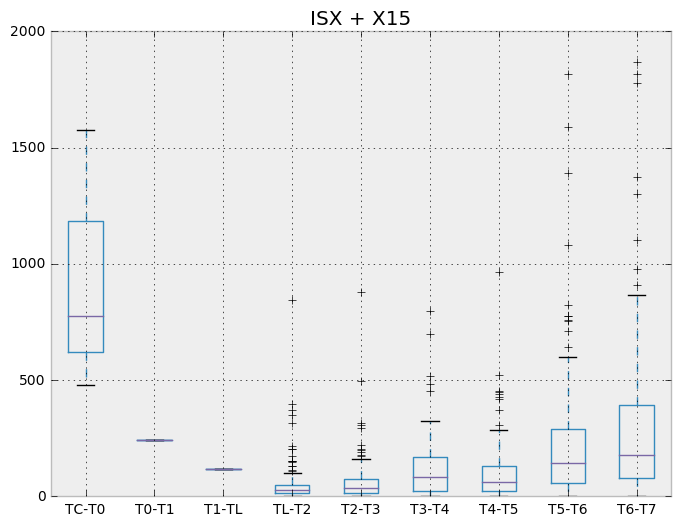

In [39]:
df_eng_type_times[df_eng_type_times['ISX + X15'] == 1][['TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7']].boxplot()
plt.title("ISX + X15")
pass

In [49]:
df_eng_type_times[df_eng_type_times['X15'] == 1]

PPS Problem #  TC-T0  T0-T1  T1-TL  TL-T2  T2-T3  T3-T4  T4-T5  T5-T6  \
24     OU006-27316    NaN    NaN    NaN    7.0    NaN   42.0    NaN   26.0   
277    IE284-26641    NaN    NaN    NaN   10.0    NaN   91.0   82.0    NaN   
278    MQ007-26346    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
280    IE284-26675    NaN    NaN    NaN   17.0  117.0   11.0   67.0   82.0   
288    KB632-26445    NaN    NaN    NaN   70.0    NaN    NaN    NaN    NaN   
293    NI353-28045    NaN    NaN    NaN   30.0    NaN    NaN    NaN    NaN   
304    NE121-27483    NaN    NaN    NaN   14.0    NaN    NaN   21.0   15.0   
545    MQ007-27874    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
548    OX003-27384    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
553    BI520-27148    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
3735   IA987-27218    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3758   NT707-27322    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3767   BI520-27742    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3786   LO048-27947    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3838   OZ701-28525    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3860   BI520-27558    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3861   AI969-27569    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3882   NE121-27492    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3891   LW459-27913    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3909   LO401-28283    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

      T6-T7  ISX1 2002  ISX2 2002  ISX3 2002  ISX1 2007  ISX2 2007  ISX3 2007  \
24     47.0          0          0          0          0          0          0   
277   171.0          0          0          0          0          0          0   
278     NaN          0          0          0          0          0          0   
280    34.0          0          0          0          0          0          0   
288     NaN          0          0          0          0          0          0   
293     NaN          0          0          0          0          0          0   
304     NaN          0          0          0          0          0          0   
545     NaN          0          0          0          0          0          0   
548     NaN          0          0          0          0          0          0   
553     NaN          0          0          0          0          0          0   
...     ...        ...        ...        ...        ...        ...        ...   
3735    NaN          0          0          0          0          0          0   
3758    NaN          0          0          0          0          0          0   
3767    NaN          0          0          0          0          0          0   
3786    NaN          0          0          0          0          0          0   
3838    NaN          0          0          0          0          0          0   
3860    NaN          0          0          0          0          0          0   
3861    NaN          0          0          0          0          0          0   
3882    NaN          0          0          0          0          0          0   
3891    NaN          0          0          0          0          0          0   
3909    NaN          0          0          0          0          0          0   

      ISX1 2010  ISX2 2010  ISX3 2010  ISX1 2013  ISX2 2013  ISX3 2013  \
24            0          0          0          0          0          0   
277           0          0          0          1          1          1   
278           0          0          0          0          0          0   
280           0          0          0          0          0          0   
288           0          0          0          0          0          0   
293           0          0          0          0          0  

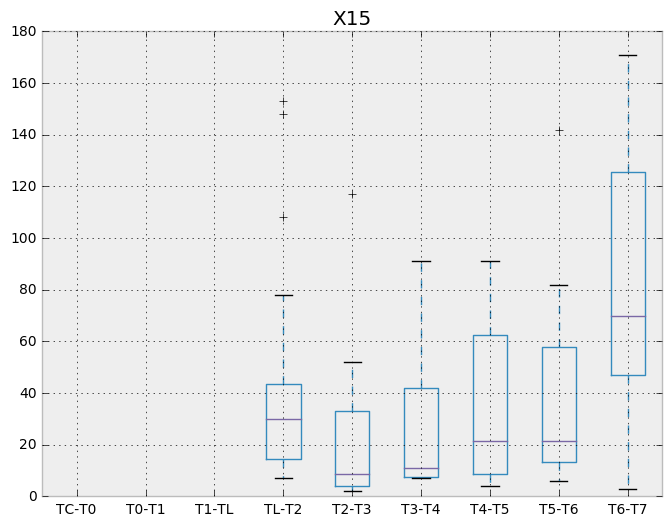

In [40]:
df_eng_type_times[df_eng_type_times['X15'] == 1][['TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7']].boxplot()
plt.title("X15")
pass

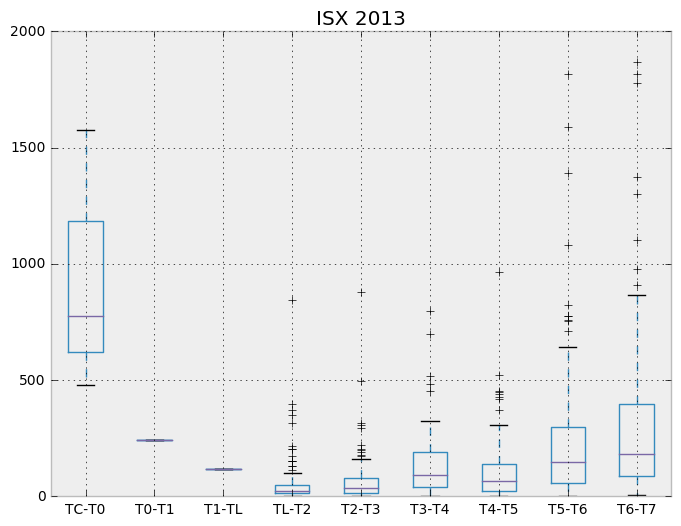

In [41]:
mask = (df_eng_type_times['ISX1 2013'] == 1) | (df_eng_type_times['ISX2 2013'] == 1) | (df_eng_type_times['ISX3 2013'] == 1)
df_eng_type_times[mask][['TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7']].boxplot()
plt.title("ISX 2013")
pass

In [87]:
df_eng_sub = df_eng_type_times[['PPS Problem #', 'ISX1 2002', 'ISX2 2002', 'ISX3 2002', 'ISX1 2007', 'ISX2 2007', 'ISX3 2007', 'ISX1 2010', 'ISX2 2010', 'ISX3 2010', 'ISX1 2013', 'ISX2 2013', 'ISX3 2013', 'ISX Catch', 'X15', 'ISX + X15']]

In [184]:
mask = (df_eng_type_times['ISX1 2002'] == 1) | \
    (df_eng_type_times['ISX2 2002'] == 1) | \
    (df_eng_type_times['ISX3 2002'] == 1) | \
    (df_eng_type_times['ISX1 2007'] == 1) | \
    (df_eng_type_times['ISX2 2007'] == 1) | \
    (df_eng_type_times['ISX3 2007'] == 1) | \
    (df_eng_type_times['ISX1 2010'] == 1) | \
    (df_eng_type_times['ISX2 2010'] == 1) | \
    (df_eng_type_times['ISX3 2010'] == 1) | \
    (df_eng_type_times['ISX1 2013'] == 1) | \
    (df_eng_type_times['ISX2 2013'] == 1) | \
    (df_eng_type_times['ISX3 2013'] == 1) | \
    (df_eng_type_times['ISX3 2002'] == 1) | \
    (df_eng_type_times['X15'] == 1) | \
    (df_eng_type_times['ISX Catch'] == 1)


In [198]:
df_eng_type_times[mask]['T0-T1'][np.isfinite(df_eng_type_times[mask]['T0-T1'])]

4        16.0
12       10.0
14      816.0
24       13.0
38       14.0
51       70.0
52       46.0
71       63.0
73       76.0
88       33.0
        ...  
3735     11.0
3749    829.0
3751    208.0
3758    172.0
3786     33.0
3838    132.0
3882      1.0
3891    414.0
3909     44.0
3911     67.0
Name: T0-T1, Length: 388, dtype: float64

In [205]:
step_cols = ['TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T0-T6', 'T1-T2']
for col in step_cols:
    median_val = np.median(df_eng_type_times[mask][col][np.isfinite(df_eng_type_times[mask][col])])
    mean_val = np.mean(df_eng_type_times[mask][col][np.isfinite(df_eng_type_times[mask][col])])
    sd_val = np.sqrt(np.var(df_eng_type_times[mask][col][np.isfinite(df_eng_type_times[mask][col])]))
    print("{},{},{},{}".format(col, median_val, mean_val, sd_val))

TC-T0,74.0,230.66862170087975,429.46504797459903
T0-T1,42.0,125.93467336683418,231.05268331291762
T1-TL,29.0,87.58379888268156,154.35268497060733
TL-T2,41.0,71.53968253968254,103.47088009904355
T2-T3,86.0,130.57831325301206,166.733039670117
T3-T4,140.5,195.29651162790697,179.72588750370394
T4-T5,111.5,190.66666666666666,245.17446711203755
T5-T6,78.0,142.85714285714286,192.03061946631314
T6-T7,38.0,70.00980392156863,92.55083341941454
T0-T6,474.0,625.6268656716418,460.86193211445175
T1-T2,83.0,153.11145510835914,191.19927836774662


In [207]:
df_eng_type_times[mask].shape

(613, 27)

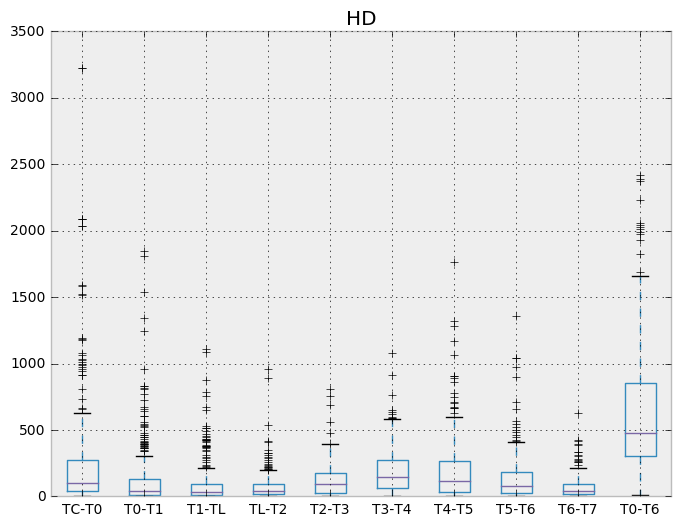

In [191]:
df_eng_type_times[mask][['TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T0-T6']].boxplot()
plt.title("HD")
pass

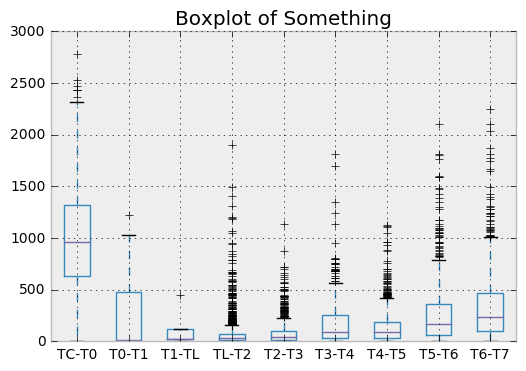

In [59]:
df_times[['TC-T0', 'T0-T1', 'T1-TL', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7']].boxplot()
plt.title("Boxplot of Something")
pass

In [695]:
df_times.Entities[np.where([type(df_times.Entities[x]) == float for x in range(df_times.shape[0])])[0]] = ''
bus_entities = [df_times.Entities[x].split(",") for x in range(df_times.shape[0])]

unique_ents = set()
for i in range(len(bus_entities)):
    for j in range(len(bus_entities[i])):
        unique_ents.add(bus_entities[i][j])
        
ents = pd.DataFrame(np.zeros(len(bus_entities)*len(unique_ents)).reshape(len(bus_entities), len(unique_ents)), columns = list(unique_ents))

for i in range(len(bus_entities)):
    for j in range(len(bus_entities[i])):
        ents[bus_entities[i][j]][i] += 1

del ents['']

ents['Intercept'] = 1

In [696]:
df_times.Total[df_times.Total == 0] = float('NaN')

In [705]:
sum(df_times['T3-T4'][np.isfinite(df_times['T3-T4'])] < 10)

48

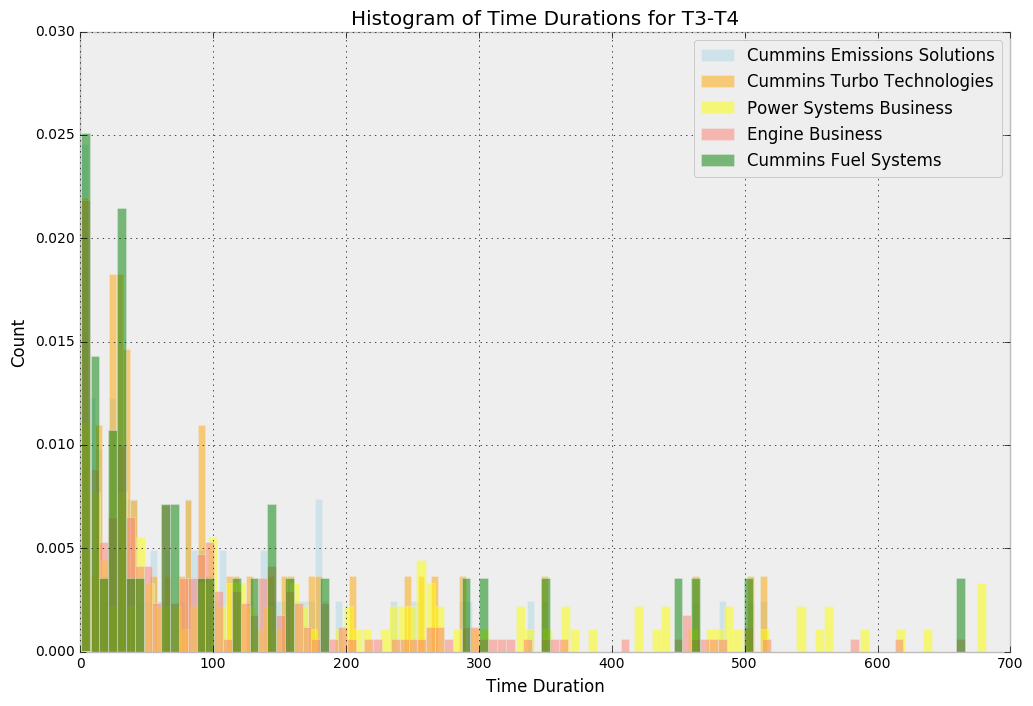

In [758]:
step = 'T3-T4'
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df_times[step][ents[res2['Entity'][0]] == 1][np.isfinite(df_times[step][ents[res2['Entity'][0]] == 1])],
            color='lightblue', alpha=0.5, bins = 100, label = res2['Entity'][0], normed=True)
ax.hist(df_times[step][ents[res2['Entity'][1]] == 1][np.isfinite(df_times[step][ents[res2['Entity'][1]] == 1])],
            color='orange', alpha=0.5, bins = 100, label = res2['Entity'][1], normed=True)
ax.hist(df_times[step][ents[res2['Entity'][2]] == 1][np.isfinite(df_times[step][ents[res2['Entity'][2]] == 1])],
            color='yellow', alpha=0.5, bins = 100, label = res2['Entity'][2], normed=True)
ax.hist(df_times[step][ents[res2['Entity'][3]] == 1][np.isfinite(df_times[step][ents[res2['Entity'][3]] == 1])],
            color='salmon', alpha=0.5, bins = 100, label = res2['Entity'][3], normed=True)
ax.hist(df_times[step][ents[res2['Entity'][4]] == 1][np.isfinite(df_times[step][ents[res2['Entity'][4]] == 1])],
            color='green', alpha=0.5, bins = 100, label = res2['Entity'][4], normed=True)
ax.set(title='Histogram of Time Durations for T3-T4',
       ylabel='Count', xlabel = 'Time Duration')
plt.legend()
plt.show()

(array([63., 42., 24., 27., 29., 25., 23., 42., 21., 24., 18., 22., 20.,
        14., 24., 18., 20., 20., 21., 18., 18., 22., 13., 11., 14., 13.,
        12., 13., 12.,  9., 11., 14.,  9.,  9., 11., 16., 12.,  8.,  9.,
        10., 10.,  6., 10.,  8., 10.,  6.,  6.,  4., 10.,  3., 13.,  7.,
         4.,  4.,  3.,  9.,  4.,  9.,  5.,  7.,  7.,  5.,  4.,  5.,  4.,
         5.,  4.,  4.,  2.,  8.,  6.,  5.,  4.,  2.,  3.,  1.,  2.,  3.,
         3.,  3.,  4.,  3.,  5.,  3.,  3.,  5.,  3.,  2.,  1.,  2.,  2.,
         1.,  1.,  3.,  2.,  2.,  1.,  1.,  0.,  1.]),
 array([  1.  ,   9.14,  17.28,  25.42,  33.56,  41.7 ,  49.84,  57.98,
         66.12,  74.26,  82.4 ,  90.54,  98.68, 106.82, 114.96, 123.1 ,
        131.24, 139.38, 147.52, 155.66, 163.8 , 171.94, 180.08, 188.22,
        196.36, 204.5 , 212.64, 220.78, 228.92, 237.06, 245.2 , 253.34,
        261.48, 269.62, 277.76, 285.9 , 294.04, 302.18, 310.32, 318.46,
        326.6 , 334.74, 342.88, 351.02, 359.16, 367.3 , 375.44, 383.58,
  

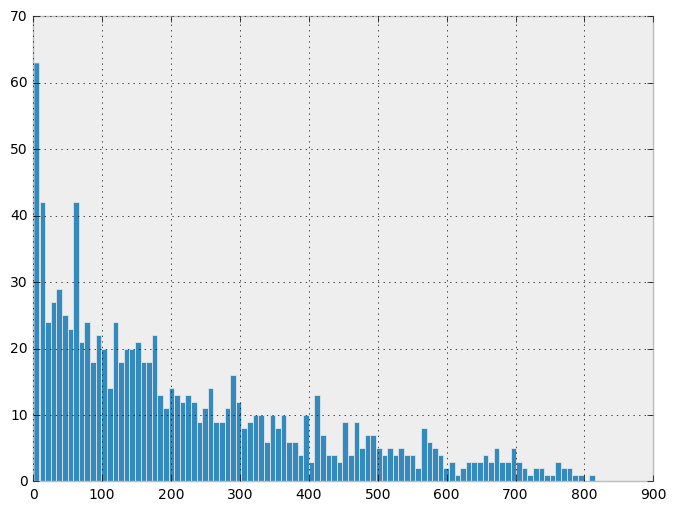

In [290]:
plt.hist(df_times['T5-T6'][np.isfinite(df_times['T5-T6'])], bins = 100)

In [342]:
all_vals = np.array([all(np.isfinite(df_times[['TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6']].iloc[x,:])) for x in range(df_times.shape[0])])

In [343]:
np.sum(all_vals)

99

In [381]:
clf = linear_model.OLS(df_times['T3-T4'], ents[res2['Entity']], missing = 'drop')
clf = clf.fit()
clf.summary()

In [382]:
#clf = linear_model.OLS(df_times['T4-T5'], ents, missing = 'drop')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  T3-T4   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     9.152
Date:                Mon, 22 Jan 2018   Prob (F-statistic):           3.35e-08
Time:                        15:55:35   Log-Likelihood:                -2309.4
No. Observations:                 359   AIC:                             4631.
Df Residuals:                     353   BIC:                             4654.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Cummins Emissions Solutions   -21.4819     24.332     -0.883      0.378     -69.337      26.373
Cummins Turbo Technologies     -6.2018     27.335     -0.227      0.821     -59.963      47.559
Power Systems Business         42.0689     23.551      1.786      0.075      -4.250      88.388
Engine Business               -80.2870     26.166     -3.068      0.002    -131.748     -28.826
Cummins Fuel Systems           16.7834     27.173      0.618      0.537     -36.658      70.225
Intercept                     188.8827     25.236      7.485      0.000     139.250     238.515
==============================================================================
Omnibus:                       75.216   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.642
Skew:                           1.257   Prob(JB):                     3.85e-27
Kurtosis:                       4.347   Cond. No.                         6.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [380]:
ents_sub = ents[np.isfinite(df_times['T5-T6'])]
res = pd.DataFrame(np.sum(ents_sub)).reset_index()
res.columns = ['Entity', "Number"]
res.sort_values(by = 'Entity', ascending = False)

Entity  Number
10                                XCEC     0.0
11                                 TCL     2.0
9               Power Systems Business   279.0
2                                 PSBU     1.0
17                           Intercept  1024.0
8                                 GCIC     0.0
14                     Engine Business   797.0
1                                  EBU     0.0
4                Distribution Business     2.0
12                                DCEC     1.0
3           Cummins Turbo Technologies   197.0
16                Cummins Fuel Systems   133.0
15                  Cummins Filtration    74.0
0          Cummins Emissions Solutions   234.0
13      Cummins Electronics - IP Owned    93.0
5   Cummins Electronics - IP Not Owned    93.0
7                                 CCEC     3.0
6                                BFCEC    47.0

In [388]:
df_times

PPS Problem #                                     Entities  \
0      KMFD-8AD4AB                              Engine Business   
1      RGEL-8GJJ9Z                              Engine Business   
2      KMFD-85DKPQ                              Engine Business   
3      MT853-17529  Engine Business,Cummins Emissions Solutions   
4      CFEN-8SKLW4         Engine Business,Cummins Fuel Systems   
5      MC160-18328                                        BFCEC   
6      RSAN-9C3S5U                              Engine Business   
7      FHBY-9GVQU8                              Engine Business   
8      JH229-18238                       Power Systems Business   
9      RMHA-9FUHS9                                        BFCEC   
...            ...                                          ...   
3955   KO340-17228                                          EBU   
3956   KC847-22670                       Power Systems Business   
3957   JSTG-997NXA                                          EBU   
3958   VCHN-9DGCVN                              Engine Business   
3959   JX464-21556                                          EBU   
3960   TARK-8GWT6Q                              Engine Business   
3961   JHUN-99MCSL                              Engine Business   
3962   ME322-24007                                          EBU   
3963   KC427-25928                                                
3964   KE092-18434                                          EBU   

     Failure Recognition Date First Customer Failure Date (Tc)  \
0                  2010-10-18                              NaT   
1                  2011-05-04                              NaT   
2                  2010-05-12                       2015-08-25   
3                  2014-06-23                       2014-06-23   
4                  2012-03-13                       2015-12-03   
5                  2014-11-17                       2014-10-26   
6                  2013-09-16                       2013-03-01   
7                  2014-03-04                       2012-12-27   
8                  2014-08-12                       2014-01-24   
9                  2014-01-05                       2013-11-24   
...                       ...                              ...   
3955               2014-03-04                       2012-12-27   
3956               2016-01-20                       2015-11-20   
3957               2013-04-11                       2013-03-20   
3958               2013-10-07                       2013-06-04   
3959               2014-06-20                       2014-04-30   
3960               2011-03-09                              NaT   
3961               2012-06-29                              NaT   
3962               2016-03-11                       2016-03-10   
3963               2016-07-05                       2016-05-02   
3964               2014-06-11                       2013-12-19   

     PDF Approval Date (T1) PTF Launch Date (TL) Preliminary Step 2  \
0                2010-10-22           2010-11-16                NaT   
1                2011-05-04           2011-07-12         2011-09-10   
2                2010-05-13           2010-06-02         2012-01-13   
3                2015-06-18           2015-07-16         2015-07-17   
4                2012-03-29           2012-10-16         2012-11-01   
5                2014-11-20           2015-01-12         2015-02-15   
6                2013-12-18           2014-07-09         2014-08-11   
7                2014-03-05           2015-02-19         2015-03-25   
8                2014-11-12           2016-10-20         2016-10-20   
9                2014-06-02           2014-06-03         2015-01-23   
...                     ...                  ...                ...   
3955                    NaT                  NaT                NaT   
3956             2016-02-03                  NaT                NaT   
3957                    NaT                  NaT                NaT   
3958        

In [410]:
df_dates = df_times[['PTF Launch Date (TL)', 'Preliminary Step 2', 'Preliminary Step 3', 'Preliminary Step 4', 'Preliminary Step 5', 'Max Step 6 Value', 'TL-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6']]

In [411]:
df_dates['TL Year'] = [df_dates['PTF Launch Date (TL)'][x].to_pydatetime().year for x in range(df_dates.shape[0])]
df_dates['TL Month'] = [df_dates['PTF Launch Date (TL)'][x].to_pydatetime().month for x in range(df_dates.shape[0])]

df_dates['T2 Year'] = [df_dates['Preliminary Step 2'][x].to_pydatetime().year for x in range(df_dates.shape[0])]
df_dates['T2 Month'] = [df_dates['Preliminary Step 2'][x].to_pydatetime().month for x in range(df_dates.shape[0])]

df_dates['T3 Year'] = [df_dates['Preliminary Step 3'][x].to_pydatetime().year for x in range(df_dates.shape[0])]
df_dates['T3 Month'] = [df_dates['Preliminary Step 3'][x].to_pydatetime().month for x in range(df_dates.shape[0])]

df_dates['T4 Year'] = [df_dates['Preliminary Step 4'][x].to_pydatetime().year for x in range(df_dates.shape[0])]
df_dates['T4 Month'] = [df_dates['Preliminary Step 4'][x].to_pydatetime().month for x in range(df_dates.shape[0])]

df_dates['T5 Year'] = [df_dates['Preliminary Step 5'][x].to_pydatetime().year for x in range(df_dates.shape[0])]
df_dates['T5 Month'] = [df_dates['Preliminary Step 5'][x].to_pydatetime().month for x in range(df_dates.shape[0])]

In [729]:
def boxPlotByMonth(step_start, step_end):
    months = np.arange(1, 13)
    all_days = []
    for month in months:
        days = df_dates[df_dates['{} Month'.format(step_start)] == month]['{}-{}'.format(step_start, step_end)][~df_dates[df_dates['{} Month'.format(step_start)] == month]['{}-{}'.format(step_start, step_end)].isnull()]
        all_days.append(days)

    plt.boxplot(all_days, labels = months)
    plt.xlabel('Month of Project Start')
    plt.ylabel('Time Duration (Days)')
    plt.title("Length of {} By Month Start Date".format(step_start))
    pass

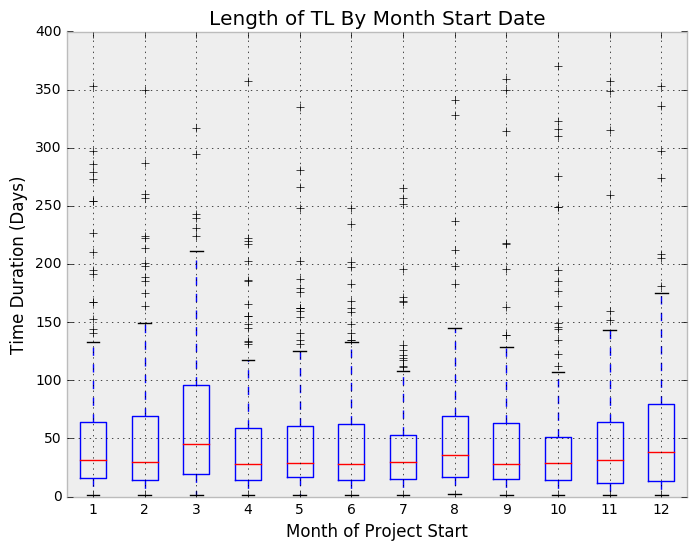

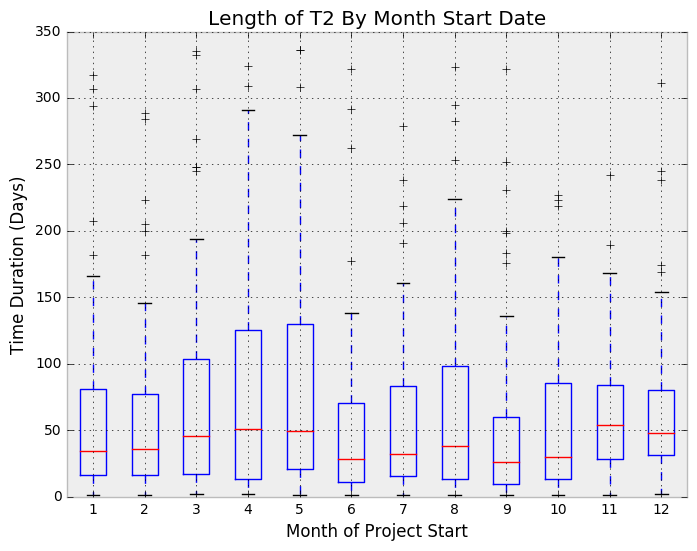

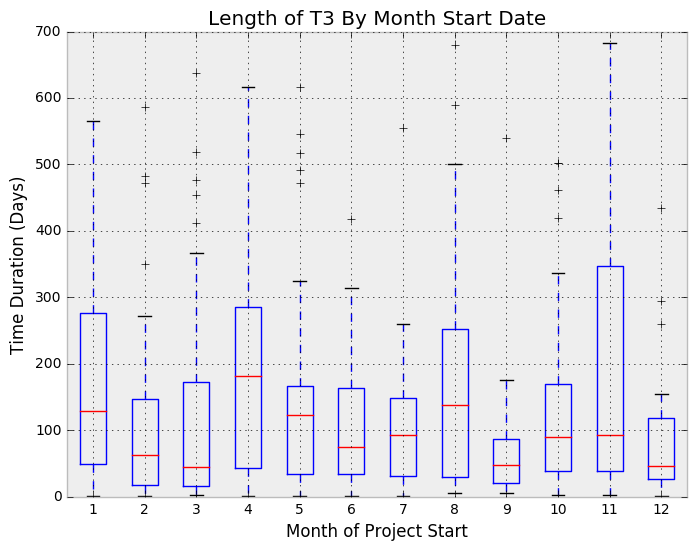

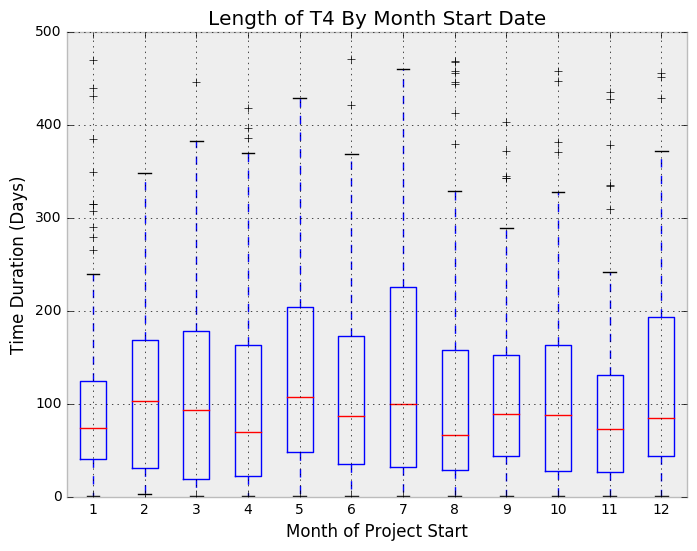

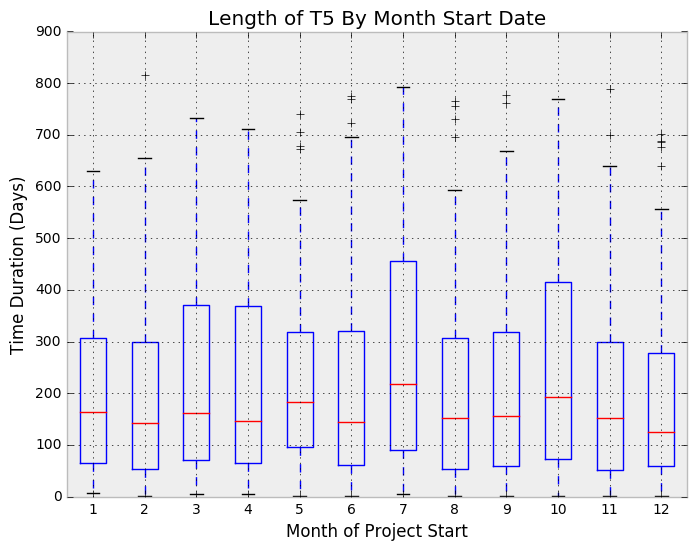

In [731]:
plt.figure(1)
boxPlotByMonth('TL', 'T2')
plt.figure(2)
boxPlotByMonth('T2', 'T3')
plt.figure(3)
boxPlotByMonth('T3', 'T4')
plt.figure(4)
boxPlotByMonth('T4', 'T5')
plt.figure(5)
boxPlotByMonth('T5', 'T6')

In [412]:
def boxPlotByYear(step_start, step_end):
    years = np.arange(2011, 2020)
    all_days = []
    for year in years:
        days = df_dates[df_dates['{} Year'.format(step_start)] == year]['{}-{}'.format(step_start, step_end)][~df_dates[df_dates['{} Year'.format(step_start)] == year]['{}-{}'.format(step_start, step_end)].isnull()]
        all_days.append(days)

    plt.boxplot(all_days, labels = years)
    plt.xlabel('Year of Project Start')
    plt.ylabel('Time Duration (Days)')
    plt.title("Length of {} By Year Start Date".format(step_start))
    pass

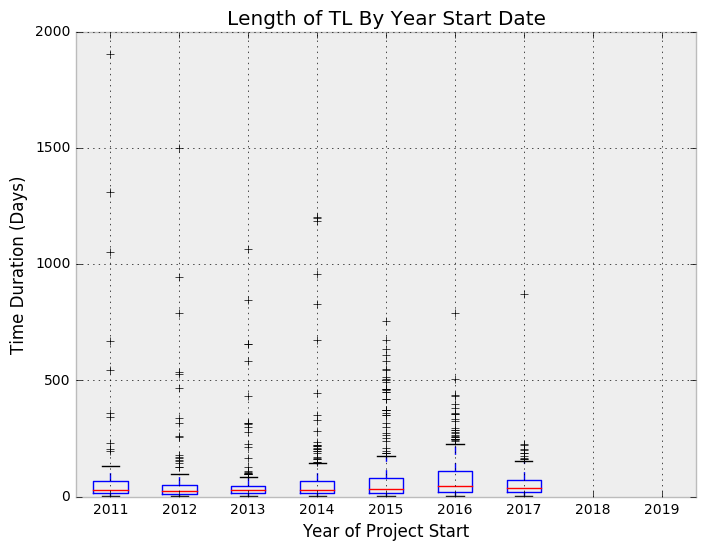

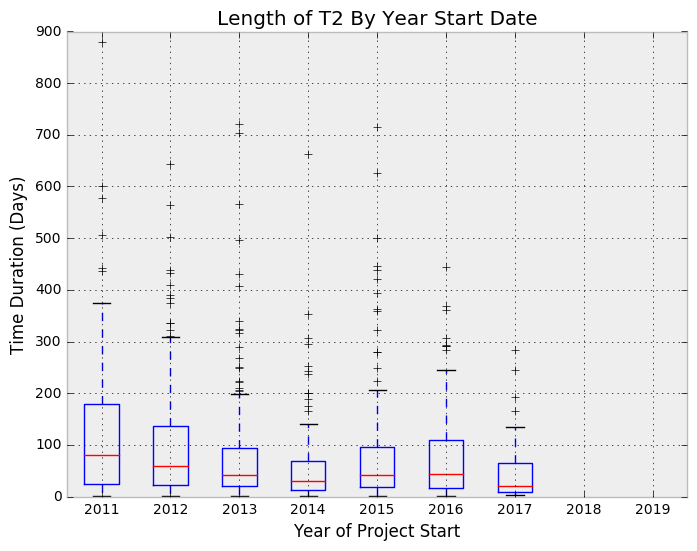

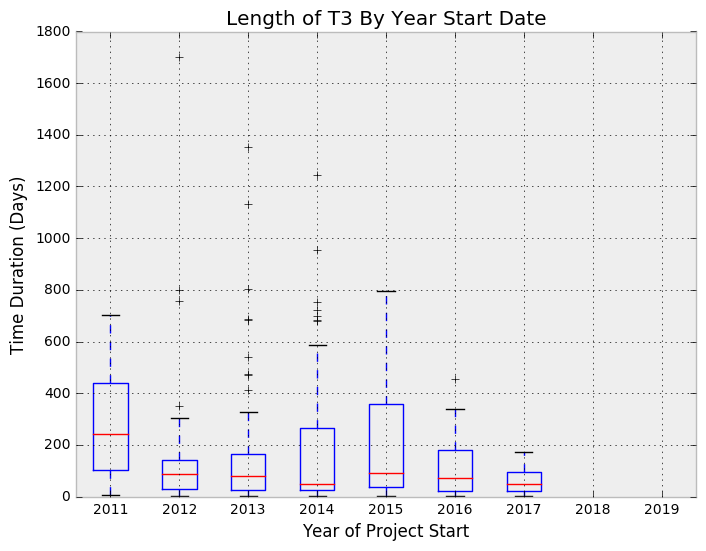

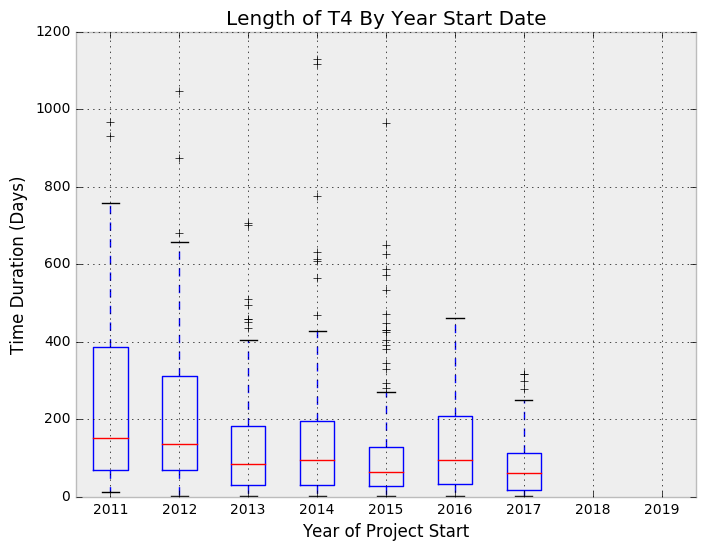

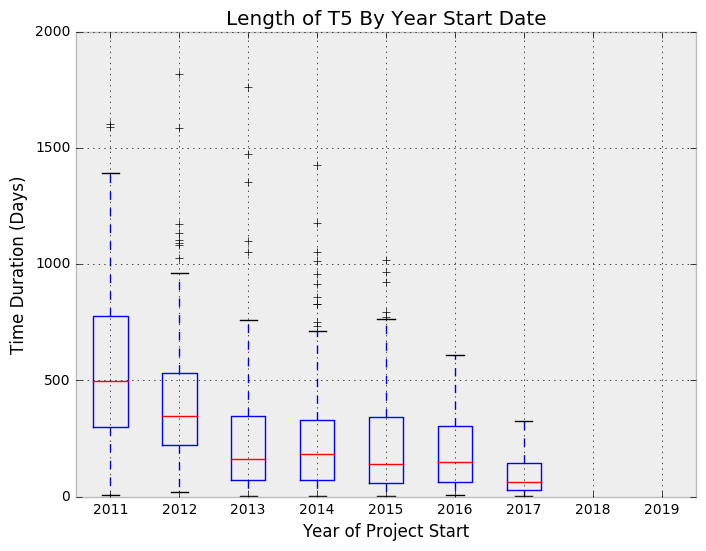

In [413]:
plt.figure(1)
boxPlotByYear('TL', 'T2')
plt.figure(2)
boxPlotByYear('T2', 'T3')
plt.figure(3)
boxPlotByYear('T3', 'T4')
plt.figure(4)
boxPlotByYear('T4', 'T5')
plt.figure(5)
boxPlotByYear('T5', 'T6')

In [744]:
df_engine = df[['PPS Problem #', 'ISX + X15', 'Is this issue related to an externally supplied component?']]
df_engine.columns.values[2] = "External Component"

In [748]:
df_engine = df_times.merge(df_engine, on = 'PPS Problem #', how = 'left')

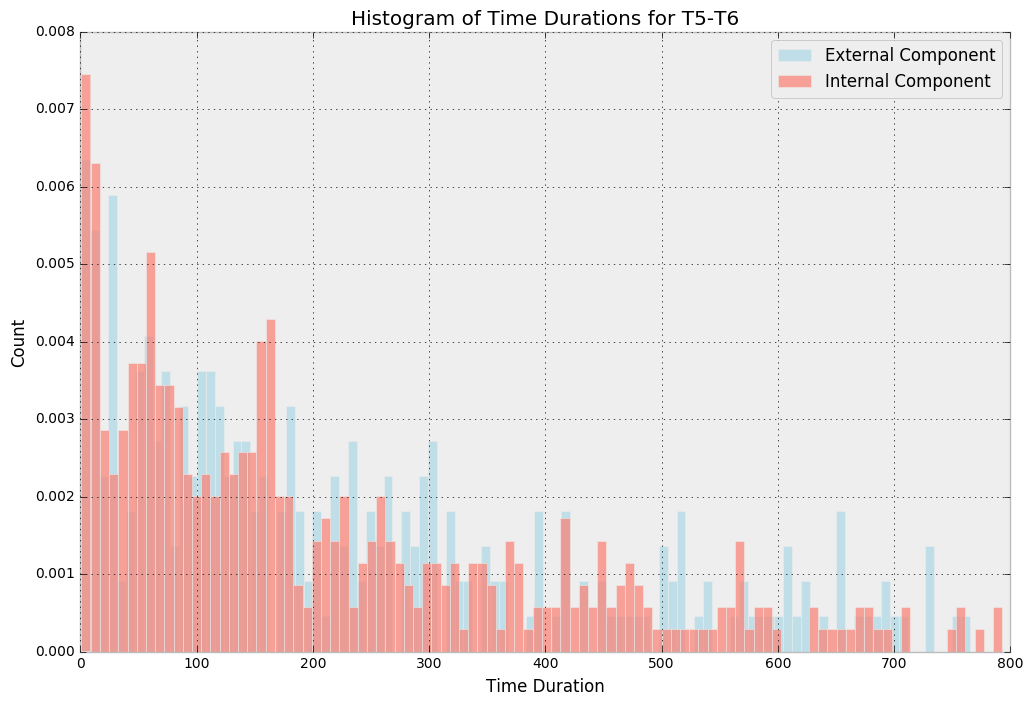

In [775]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df_engine[df_engine['External Component'] == 'Y']['T5-T6'].dropna(),
            color='lightblue', alpha=0.7, bins = 100, label = 'External Component', normed=True)
ax.hist(df_engine[df_engine['External Component'] == 'N']['T5-T6'].dropna(),
            color='salmon', alpha=0.7, bins = 100, label = 'Internal Component', normed=True)
ax.set(title='Histogram of Time Durations for T5-T6',
       ylabel='Count', xlabel = 'Time Duration')
plt.legend()
plt.show()

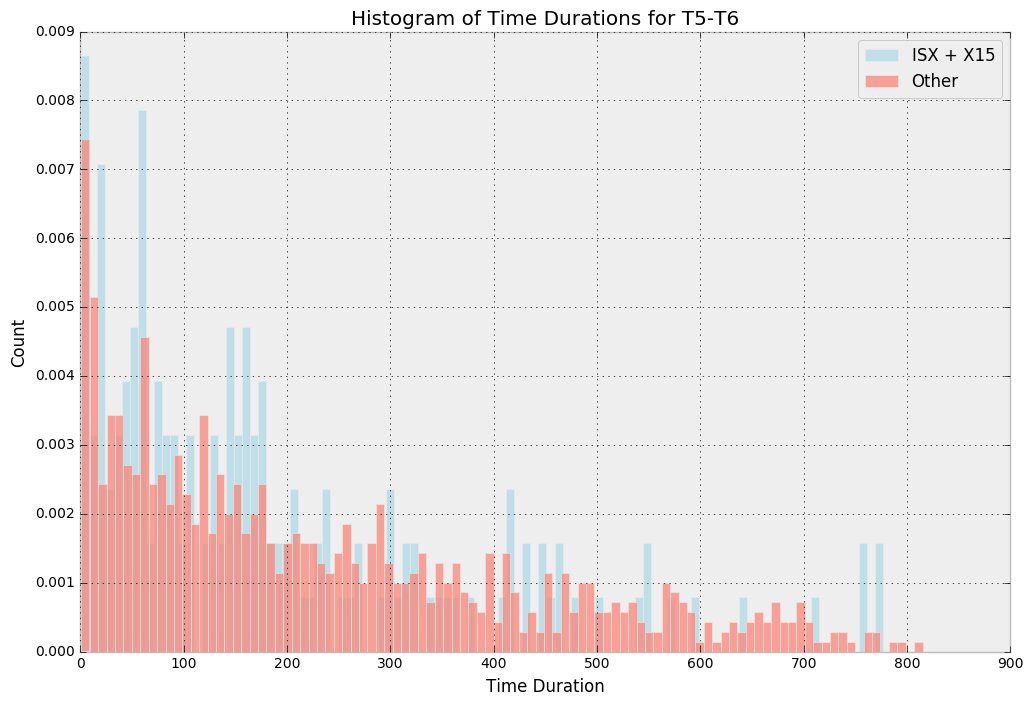

In [767]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df_engine[df_engine['ISX + X15'] == 1]['T5-T6'].dropna(),
            color='lightblue', alpha=0.7, bins = 100, label = 'ISX + X15', normed=True)
ax.hist(df_engine[df_engine['ISX + X15'] == 0]['T5-T6'].dropna(),
            color='salmon', alpha=0.7, bins = 100, label = 'Other', normed=True)
ax.set(title='Histogram of Time Durations for T5-T6',
       ylabel='Count', xlabel = 'Time Duration')
plt.legend()
plt.show()

In [418]:
np.isdate(df_times['PTF Launch Date (TL)'])

AttributeError: module 'numpy' has no attribute 'isdate'

In [537]:
pos_idxs = np.logical_and(~np.isnat(df_times['PTF Launch Date (TL)']), ~np.isnat(df_times['Max Step 6 Value']))

In [538]:
df_pm = df[['PPS Problem #', 'Project Lead', 'PTF Launch Date (TL)', 'Max Step 6 Value']].reset_index(drop = True)

In [539]:
df_pm['Max Step 6 Value'][df_pm['Max Step 6 Value'] == '00-Jan-1900'] = float('NaN')

In [540]:
df_pm['PTF Launch Date (TL)'] = pd.to_datetime(df_pm['PTF Launch Date (TL)'])
df_pm['Max Step 6 Value'][1748] = '25-Sep-2012'
df_pm['Max Step 6 Value'] = pd.to_datetime(df_pm['Max Step 6 Value'])

In [541]:
df_pm['Total'] = (df_pm['Max Step 6 Value'] - df_pm['PTF Launch Date (TL)']).apply(calc_days, val = 0)


In [542]:
df_pm = df_pm[pos_idxs]

In [544]:
df_pm2 = df_pm[np.logical_and(df_pm['PTF Launch Date (TL)'] > '2017-01-01', df_pm['Max Step 6 Value'] < '2018-01-22')]

In [545]:
df_pm2 = df_pm2[np.isfinite(df_pm2.Total)]

In [546]:
df_pm2.sort_values(by = 'Total')

PPS Problem #                Project Lead PTF Launch Date (TL)  \
531    MW321-26035                     Tom  Yu           2017-02-15   
1032   MF375-25049               Huaizhi  Zhao           2017-09-29   
1593   HU425-26097                    Fei  Fan           2017-03-22   
198    IW614-25764  Uma Shankar  Kombanaipudur           2017-02-20   
530    LU634-25607                Grant  Niese           2017-04-17   
810    FY349-26847           Sachin  Kaulavkar           2017-10-25   
54     OB929-24812                 Lizhan  Sun           2017-01-02   
688    IC646-26209   Rodrigo  Queiros Santolin           2017-05-10   
299    MT853-27363                 Vincent  Li           2017-10-10   
542    BH190-27632               Jason V Dukes           2017-08-03   
...            ...                         ...                  ...   
1734   HO284-25600            Patrick  Stahley           2017-01-12   
64     LB451-25276               Kyle  Troesch           2017-01-27   
802    NK721-25667                 Yash  Nawal           2017-03-02   
1299   JK567-24411               Aparna  Tadas           2017-01-18   
1588   FP296-25244             Vishal T Vaidya           2017-01-17   
43     JG148-23569     Danilo  Carlos Teixeira           2017-01-18   
1833   MI609-25823                Scott  Ragon           2017-02-14   
263    LU616-23045            Timothy  Schiebe           2017-02-15   
1278   FB233-25068            Peter  Treglohan           2017-01-24   
1295   GP506-25170             Cheng-lin  Hung           2017-01-13   

     Max Step 6 Value  Total  
531        2017-02-16    1.0  
1032       2017-10-10   11.0  
1593       2017-04-06   15.0  
198        2017-03-10   18.0  
530        2017-05-08   21.0  
810        2017-11-17   23.0  
54         2017-01-27   25.0  
688        2017-06-05   26.0  
299        2017-11-10   31.0  
542        2017-09-06   34.0  
...               ...    ...  
1734       2017-11-06  298.0  
64         2017-11-30  307.0  
802        2018-01-10  314.0  
1299       2017-11-29  315.0  
1588       2017-11-29  316.0  
43         2017-12-01  317.0  
1833       2017-12-30  319.0  
263        2018-01-18  337.0  
1278       2017-12-31  341.0  
1295       2018-01-19  371.0  

[129 rows x 5 columns]

In [547]:
ents['PPS Problem #'] = df_times['PPS Problem #']

In [548]:
df_pm3 = df_pm2.merge(ents, on = 'PPS Problem #', how = 'left')

In [550]:
df_emissions = df_pm3[df_pm3['Cummins Emissions Solutions'] == 1][['PPS Problem #', 'Project Lead', 'PTF Launch Date (TL)', 'Max Step 6 Value', 'Total']]
df_turbo = df_pm3[df_pm3['Cummins Turbo Technologies'] == 1][['PPS Problem #', 'Project Lead', 'PTF Launch Date (TL)', 'Max Step 6 Value', 'Total']]
df_engine = df_pm3[df_pm3['Engine Business'] == 1][['PPS Problem #', 'Project Lead', 'PTF Launch Date (TL)', 'Max Step 6 Value', 'Total']]

In [514]:
df_pm3.to_csv("~/Desktop/project_leads_entities.csv", index = False)

In [618]:
df = df.reset_index(drop = True)

In [597]:
df['Project Name / Summary Statement'][df['Project Name / Summary Statement'] == float('NaN')

Series([], Name: Project Name / Summary Statement, dtype: object)

In [631]:
df['Project Name / Summary Statement'][df['Project Name / Summary Statement'].isnull()] = ''

In [632]:
nox_idxs = ['NOx' in df['Project Name / Summary Statement'][x] for x in range(df.shape[0])]

In [634]:
df_nox = df[['PPS Problem #', 'Project Name / Summary Statement']][nox_idxs]

In [637]:
df_nox2 = df_nox.merge(df_pm3, on = 'PPS Problem #', how = 'left').reset_index(drop = True)

In [642]:
df_nox2[~df_nox2['Project Lead'].isnull()]

PPS Problem #                   Project Name / Summary Statement  \
7    FY349-27301  FC 1887 - Outlet NOx Sensor Circuit - Voltage ...   
16   LM497-22942  In LPO 1512 TML vehicle, FC 2772,2773 : After ...   
17   IA987-26584  EX: B6.7,L9, X15 EPA17 System Out NOx Sensor P...   
22   NL145-25958  IC17 Ð NOx sensor harness bracket - rivet fail...   
38   MB524-26213    NOx sensor SAE14 version with electric failure    

          Project Lead PTF Launch Date (TL) Max Step 6 Value  Total  \
7        Sandeep  Hake           2017-07-12       2017-09-28   78.0   
16  Dhaleshwar  Baghel           2017-03-23       2017-06-22   91.0   
17      Jim M O^Rourke           2017-04-24       2017-12-29  249.0   
22  Christopher  Wolff           2017-02-17       2017-05-01   73.0   
38     Raphael  Wetzel           2017-03-22       2017-12-15  268.0   

    Cummins Emissions Solutions  EBU  PSBU  Cummins Turbo Technologies  \
7                           1.0  0.0   0.0                         0.0   
16                          1.0  0.0   0.0                         0.0   
17                          1.0  0.0   0.0                         0.0   
22                          1.0  0.0   0.0                         1.0   
38                          1.0  0.0   0.0                         0.0   

    Distribution Business  Cummins Electronics - IP Not Owned  BFCEC  CCEC  \
7                     0.0                                 0.0    0.0   0.0   
16                    0.0                                 0.0    0.0   0.0   
17                    0.0                                 0.0    0.0   0.0   
22                    0.0                                 0.0    0.0   0.0   
38                    0.0                                 0.0    0.0   0.0   

    GCIC  Power Systems Business  XCEC  TCL  DCEC  \
7    0.0                     0.0   0.0  0.0   0.0   
16   0.0                     0.0   0.0  0.0   0.0   
17   0.0                     1.0   0.0  0.0   0.0   
22   0.0                     0.0   0.0  0.0   0.0   
38   0.0                     0.0   0.0  0.0   0.0   

    Cummins Electronics - IP Owned  Engine Business  Cummins Filtration  \
7                              0.0              1.0                 0.0   
16                             0.0              1.0                 0.0   
17                             0.0              1.0                 0.0   
22                             0.0              1.0                 1.0   
38                             0.0              1.0                 0.0   

    Cummins Fuel Systems  Intercept  
7                    0.0        1.0  
16                   0.0        1.0  
17                   0.0        1.0  
22                   0.0        1.0  
38                   0.0        1.0

In [558]:
df_emissions.sort_values(by = 'Total').reset_index(drop = True)

PPS Problem #          Project Lead PTF Launch Date (TL) Max Step 6 Value  \
0    MW321-26035               Tom  Yu           2017-02-15       2017-02-16   
1    MF375-25049         Huaizhi  Zhao           2017-09-29       2017-10-10   
2    FY349-26847     Sachin  Kaulavkar           2017-10-25       2017-11-17   
3    MT853-27363           Vincent  Li           2017-10-10       2017-11-10   
4    MF375-27474         Huaizhi  Zhao           2017-09-29       2017-11-30   
5    KB632-26445       Jeremy D Harris           2017-04-26       2017-06-29   
6    GP716-25965         Melissa H Dye           2017-04-24       2017-06-30   
7    NL145-25958    Christopher  Wolff           2017-02-17       2017-05-01   
8    FY349-27301         Sandeep  Hake           2017-07-12       2017-09-28   
9    MB524-25035       Raphael  Wetzel           2017-06-29       2017-09-15   
..           ...                   ...                  ...              ...   
26   LT914-26913  Ravi Kanth  Pulipaka           2017-05-23       2017-12-21   
27   JZ327-25890     Tory  Jaloszynski           2017-02-15       2017-09-15   
28   LN217-26854         Ashik  Pasham           2017-06-05       2018-01-20   
29   HL598-26463         Maneet  Singh           2017-04-12       2017-11-29   
30   IA987-26584        Jim M O^Rourke           2017-04-24       2017-12-29   
31   NG509-26347     David  Klippstein           2017-04-05       2017-12-29   
32   MB524-26213       Raphael  Wetzel           2017-03-22       2017-12-15   
33   BV099-26457         Carlos  Souza           2017-04-20       2018-01-15   
34   IS364-26122          Wayne  Percy           2017-03-14       2017-12-20   
35   HO284-25600      Patrick  Stahley           2017-01-12       2017-11-06   

    Total  
0     1.0  
1    11.0  
2    23.0  
3    31.0  
4    62.0  
5    64.0  
6    67.0  
7    73.0  
8    78.0  
9    78.0  
..    ...  
26  212.0  
27  212.0  
28  229.0  
29  231.0  
30  249.0  
31  268.0  
32  268.0  
33  270.0  
34  281.0  
35  298.0  

[36 rows x 5 columns]

In [521]:
df_times

PPS Problem #                                     Entities  \
0      KMFD-8AD4AB                              Engine Business   
1      RGEL-8GJJ9Z                              Engine Business   
2      KMFD-85DKPQ                              Engine Business   
3      MT853-17529  Engine Business,Cummins Emissions Solutions   
4      CFEN-8SKLW4         Engine Business,Cummins Fuel Systems   
5      MC160-18328                                        BFCEC   
6      RSAN-9C3S5U                              Engine Business   
7      FHBY-9GVQU8                              Engine Business   
8      JH229-18238                       Power Systems Business   
9      RMHA-9FUHS9                                        BFCEC   
...            ...                                          ...   
3955   KO340-17228                                          EBU   
3956   KC847-22670                       Power Systems Business   
3957   JSTG-997NXA                                          EBU   
3958   VCHN-9DGCVN                              Engine Business   
3959   JX464-21556                                          EBU   
3960   TARK-8GWT6Q                              Engine Business   
3961   JHUN-99MCSL                              Engine Business   
3962   ME322-24007                                          EBU   
3963   KC427-25928                                                
3964   KE092-18434                                          EBU   

     Failure Recognition Date First Customer Failure Date (Tc)  \
0                  2010-10-18                              NaT   
1                  2011-05-04                              NaT   
2                  2010-05-12                       2015-08-25   
3                  2014-06-23                       2014-06-23   
4                  2012-03-13                       2015-12-03   
5                  2014-11-17                       2014-10-26   
6                  2013-09-16                       2013-03-01   
7                  2014-03-04                       2012-12-27   
8                  2014-08-12                       2014-01-24   
9                  2014-01-05                       2013-11-24   
...                       ...                              ...   
3955               2014-03-04                       2012-12-27   
3956               2016-01-20                       2015-11-20   
3957               2013-04-11                       2013-03-20   
3958               2013-10-07                       2013-06-04   
3959               2014-06-20                       2014-04-30   
3960               2011-03-09                              NaT   
3961               2012-06-29                              NaT   
3962               2016-03-11                       2016-03-10   
3963               2016-07-05                       2016-05-02   
3964               2014-06-11                       2013-12-19   

     PDF Approval Date (T1) PTF Launch Date (TL) Preliminary Step 2  \
0                2010-10-22           2010-11-16                NaT   
1                2011-05-04           2011-07-12         2011-09-10   
2                2010-05-13           2010-06-02         2012-01-13   
3                2015-06-18           2015-07-16         2015-07-17   
4                2012-03-29           2012-10-16         2012-11-01   
5                2014-11-20           2015-01-12         2015-02-15   
6                2013-12-18           2014-07-09         2014-08-11   
7                2014-03-05           2015-02-19         2015-03-25   
8                2014-11-12           2016-10-20         2016-10-20   
9                2014-06-02           2014-06-03         2015-01-23   
...                     ...                  ...                ...   
3955                    NaT                  NaT                NaT   
3956             2016-02-03                  NaT                NaT   
3957                    NaT                  NaT                NaT   
3958        

In [643]:
df_dates

PTF Launch Date (TL) Preliminary Step 2 Preliminary Step 3  \
0              2010-11-16                NaT                NaT   
1              2011-07-12         2011-09-10         2011-08-11   
2              2010-06-02         2012-01-13                NaT   
3              2015-07-16         2015-07-17         2015-07-24   
4              2012-10-16         2012-11-01         2012-08-20   
5              2015-01-12         2015-02-15         2015-03-31   
6              2014-07-09         2014-08-11         2014-08-11   
7              2015-02-19         2015-03-25         2015-04-01   
8              2016-10-20         2016-10-20         2014-08-12   
9              2014-06-03         2015-01-23         2015-01-23   
...                   ...                ...                ...   
3955                  NaT                NaT                NaT   
3956                  NaT                NaT                NaT   
3957                  NaT                NaT                NaT   
3958                  NaT                NaT                NaT   
3959                  NaT                NaT                NaT   
3960                  NaT                NaT                NaT   
3961                  NaT                NaT                NaT   
3962                  NaT                NaT                NaT   
3963                  NaT                NaT                NaT   
3964                  NaT                NaT                NaT   

     Preliminary Step 4 Preliminary Step 5  TL-T2  T2-T3  T3-T4  T4-T5  T5-T6  \
0            2012-01-11                NaT    NaN    NaN    NaN    NaN    NaN   
1            2011-09-10         2011-10-20   60.0    NaN    NaN   62.0  495.0   
2            2012-01-13         2012-01-13    NaN    NaN    NaN    NaN    NaN   
3            2015-07-31         2015-08-07    1.0    NaN    NaN    NaN    NaN   
4            2013-02-05         2013-02-05   16.0   96.0    NaN    NaN    NaN   
5            2015-04-30         2015-05-31   34.0  101.0    NaN   27.0    NaN   
6            2014-09-15         2014-10-20   33.0   32.0    NaN    NaN    NaN   
7            2015-04-15         2015-04-30   34.0    NaN  355.0   69.0   77.0   
8            2016-10-20         2016-10-20    NaN    NaN    NaN    NaN    NaN   
9            2015-01-23         2015-02-15  234.0    NaN    NaN   10.0  655.0   
...                 ...                ...    ...    ...    ...    ...    ...   
3955                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3956                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3957                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3958                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3959                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3960                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3961                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3962                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3963                NaT                NaT    NaN    NaN    NaN    NaN    NaN   
3964                NaT                NaT    NaN    NaN    NaN    NaN    NaN   

      TL Year  TL Month  T2 Year  T2 Month  T3 Year  T3 Month  T4 Year  \
0      2010.0      11.0      NaN       NaN      NaN       NaN   2012.0   
1      2011.0       7.0   2011.0       9.0   2011.0       8.0   2011.0   
2      2010.0       6.0   2012.0       1.0      NaN       NaN   2012.0   
3      2015.0       7.0   2015.0       7.0   2015.0       7.0   2015.0   
4      2012.0      10.0   2012.0      11.0   2012.0       8.0   2013.0   
5      2015.0       1.0   2015.0       2.0   2015.0       3.0   2015.0   
6      2014.0       7.0   2014.0       8.0   2014.0       8.0   2014.0   
7      2015.0       2.0   2015.0       3.0   2015.0       4.0   2015.0   
8      2016.0      10.0   2016.0      10.0   2014.0       8.0   2016.0   
9      

In [706]:
df_times

PPS Problem #                                     Entities  \
0      KMFD-8AD4AB                              Engine Business   
1      RGEL-8GJJ9Z                              Engine Business   
2      KMFD-85DKPQ                              Engine Business   
3      MT853-17529  Engine Business,Cummins Emissions Solutions   
4      CFEN-8SKLW4         Engine Business,Cummins Fuel Systems   
5      MC160-18328                                        BFCEC   
6      RSAN-9C3S5U                              Engine Business   
7      FHBY-9GVQU8                              Engine Business   
8      JH229-18238                       Power Systems Business   
9      RMHA-9FUHS9                                        BFCEC   
...            ...                                          ...   
3955   KO340-17228                                          EBU   
3956   KC847-22670                       Power Systems Business   
3957   JSTG-997NXA                                          EBU   
3958   VCHN-9DGCVN                              Engine Business   
3959   JX464-21556                                          EBU   
3960   TARK-8GWT6Q                              Engine Business   
3961   JHUN-99MCSL                              Engine Business   
3962   ME322-24007                                          EBU   
3963   KC427-25928                                                
3964   KE092-18434                                          EBU   

     Failure Recognition Date First Customer Failure Date (Tc)  \
0                  2010-10-18                              NaT   
1                  2011-05-04                              NaT   
2                  2010-05-12                       2015-08-25   
3                  2014-06-23                       2014-06-23   
4                  2012-03-13                       2015-12-03   
5                  2014-11-17                       2014-10-26   
6                  2013-09-16                       2013-03-01   
7                  2014-03-04                       2012-12-27   
8                  2014-08-12                       2014-01-24   
9                  2014-01-05                       2013-11-24   
...                       ...                              ...   
3955               2014-03-04                       2012-12-27   
3956               2016-01-20                       2015-11-20   
3957               2013-04-11                       2013-03-20   
3958               2013-10-07                       2013-06-04   
3959               2014-06-20                       2014-04-30   
3960               2011-03-09                              NaT   
3961               2012-06-29                              NaT   
3962               2016-03-11                       2016-03-10   
3963               2016-07-05                       2016-05-02   
3964               2014-06-11                       2013-12-19   

     PDF Approval Date (T1) PTF Launch Date (TL) Preliminary Step 2  \
0                2010-10-22           2010-11-16                NaT   
1                2011-05-04           2011-07-12         2011-09-10   
2                2010-05-13           2010-06-02         2012-01-13   
3                2015-06-18           2015-07-16         2015-07-17   
4                2012-03-29           2012-10-16         2012-11-01   
5                2014-11-20           2015-01-12         2015-02-15   
6                2013-12-18           2014-07-09         2014-08-11   
7                2014-03-05           2015-02-19         2015-03-25   
8                2014-11-12           2016-10-20         2016-10-20   
9                2014-06-02           2014-06-03         2015-01-23   
...                     ...                  ...                ...   
3955                    NaT                  NaT                NaT   
3956             2016-02-03                  NaT                NaT   
3957                    NaT                  NaT                NaT   
3958        

In [707]:
idxs = np.logical_and(~np.isnat(df_times['Failure Recognition Date']), ~np.isnat(df_times['Max Step 6 Value']))

In [711]:
df_times['T0-T6'] = (df_times['Max Step 6 Value'] - df_times['Failure Recognition Date']).apply(calc_days,  val = 0)


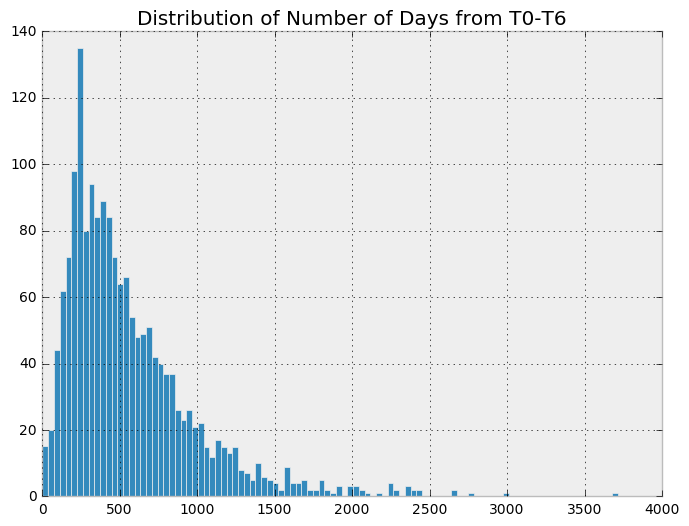

In [716]:
plt.hist(df_times['T0-T6'][np.isfinite(df_times['T0-T6'])], bins = 100)
plt.title("Distribution of Number of Days from T0-T6")
pass

In [17]:
df_people = df[['PPS Problem #', 'Project Lead', 'Sponsor', 'Service Engineering', 'Engineering', 'Manufacturing', 'Supplier Quality', 'Purchasing', 'Account Management', 'Aftermarket Parts', 'Others', 'Supplier Project Leader(if applicable)']]

In [18]:
df_people = df_times.merge(df_people, on ='PPS Problem #', how = 'left')

In [20]:
df_people['TL-T6'] = (df_people['Max Step 6 Value'] - df_times['PTF Launch Date (TL)']).apply(calc_days, val = 0)
df_people['TL-T4'] = (df_people['Max Step 6 Value'] - df_times['Step 4 Completion(T4)']).apply(calc_days, val = 0)

In [21]:
count_of_projs = df_people.groupby(by = 'Project Lead')['Entities'].count()
count_of_projs = count_of_projs[count_of_projs > 1]
ppl_w_mult_projs = np.array(count_of_projs.index)

In [22]:
df_people['Overlapping Percentage'] = 0

In [25]:
person = ppl_w_mult_projs[0]
df_sub_person = df_people[df_people['Project Lead'] == person]
combs = combinations_with_replacement(df_sub_person['PPS Problem #'], 2)

In [26]:
df_people.loc[df_people['PPS Problem #'] == 'TSOY-8YXBXQ', 'Overlapping Percentage'] = 3

In [27]:
df_people[df_people['Project Lead'] == 'ADAM P Siddle']

PPS Problem #                Entities Failure Recognition Date  \
225    APSE-98MB33  Power Systems Business               2012-10-08   
227    APSE-98TJW7  Power Systems Business               2012-12-03   
458    APSE-98LE48  Power Systems Business               2012-01-05   
715    APSE-98LD8M  Power Systems Business               2012-11-26   
1239   APSE-98JG4C  Power Systems Business               2011-10-03   
1240   APSE-98KBGP  Power Systems Business               2012-06-04   
2027   APSE-98KE3V  Power Systems Business               2010-06-09   
2035   APSE-98FDYX  Power Systems Business               2012-10-08   

     First Customer Failure Date (Tc) PDF Approval Date (T1)  \
225                        2009-10-01             2013-06-12   
227                        2012-02-14             2013-06-19   
458                        2010-12-20             2013-06-11   
715                        2012-11-26             2013-06-11   
1239                       2009-12-27             2013-06-09   
1240                       2010-06-09             2013-06-10   
2027                       2006-02-22             2013-06-10   
2035                       2009-10-01             2013-06-06   

     PTF Launch Date (TL) Preliminary Step 2 Step 2 Completion Date (T2)  \
225            2013-06-13                NaT                         NaT   
227            2013-06-20                NaT                         NaT   
458            2013-06-20                NaT                         NaT   
715            2013-06-13                NaT                         NaT   
1239           2013-06-10         2012-02-17                         NaT   
1240           2013-06-20                NaT                         NaT   
2027           2013-06-20                NaT                         NaT   
2035           2013-06-07         2012-10-31                  2013-06-07   

     Preliminary Step 3 Step 3 Completion Preliminary Step 4  \
225                 NaT               NaT                NaT   
227                 NaT               NaT                NaT   
458                 NaT               NaT                NaT   
715                 NaT               NaT                NaT   
1239                NaT               NaT                NaT   
1240                NaT               NaT                NaT   
2027                NaT               NaT                NaT   
2035         2013-01-09               NaT         2012-12-17   

     Step 4 Completion(T4) Preliminary Step 5 Step 5 Completion  \
225                    NaT                NaT               NaT   
227                    NaT                NaT               NaT   
458                    NaT                NaT               NaT   
715                    NaT                NaT               NaT   
1239                   NaT         2012-10-04        2013-06-11   
1240                   NaT                NaT               NaT   
2027                   NaT                NaT               NaT   
2035            2013-06-07         2013-01-29        2013-06-07   

     Preliminary Step 6 Max Step 6 Value  TC-T0  T0-T1  T1-TL  TL-T2  T2-T3  \
225                 NaT              NaT    NaN    NaN    NaN    NaN    NaN   
227                 NaT              NaT    NaN    NaN    NaN    NaN    NaN   
458                 NaT              NaT    NaN    NaN    NaN    NaN    NaN   
715                 NaT              NaT    NaN    NaN    NaN    NaN    NaN   
1239         2012-12-17       2012-12-17    NaN    NaN    NaN    NaN    NaN   
1240                NaT              NaT    NaN    NaN    NaN    NaN    NaN   
2027                NaT              NaT    NaN    NaN    NaN    NaN    NaN   
2035         2013-03-26       2013-03-26    NaN    NaN    NaN    NaN  219.0   

      T3-T4  T4-T5  T5-T6  T6-T7  Total   Project Lead Sponsor  \
225     NaN    NaN    NaN    NaN    0.0  ADAM P Siddle     NaN   
227     NaN    NaN    NaN    NaN    0.0  ADAM P Siddle     NaN   
458     NaN 

In [30]:
for person in ppl_w_mult_projs:
    df_sub_person = df_people[df_people['Project Lead'] == person]
    for proj in df_sub_person['PPS Problem #']:
        df_sub_proj = df_sub_person[df_sub_person['PPS Problem #'] != proj]
        r1_start = df_sub_person[df_sub_person['PPS Problem #'] == proj]['PTF Launch Date (TL)'].iloc[0].to_pydatetime()
        r1_end = df_sub_person[df_sub_person['PPS Problem #'] == proj]['Max Step 6 Value'].iloc[0].to_pydatetime()
        days = 0
        for other_proj in df_sub_proj['PPS Problem #']:
            r2_start = df_sub_person[df_sub_person['PPS Problem #'] == other_proj]['PTF Launch Date (TL)'].iloc[0].to_pydatetime()
            r2_end = df_sub_person[df_sub_person['PPS Problem #'] == other_proj]['Max Step 6 Value'].iloc[0].to_pydatetime()
            days += getOverlappingDays(r1_start, r1_end, r2_start, r2_end)
            
        project_length_1 = (r1_end - r1_start).days + 1
        if project_length_1 < 0:
            project_length_1 = float('nan')
        df_people.loc[df_people['PPS Problem #'] == proj, 'Overlapping Percentage'] = days/project_length_1
        
        #print("{} : {} : {}".format(person, days, project_length_1))



In [31]:
df_people['Overlapping Indicator'] = 0

In [32]:
df_people.loc[df_people['Overlapping Percentage'] > 0, "Overlapping Indicator"] = 1

In [38]:
df_people[df_people['Overlapping Indicator'] == 1]['TL-T4'].dropna().mean() - \
df_people[df_people['Overlapping Indicator'] == 0]['TL-T4'].dropna().mean()

86.0320286722039

In [40]:
df_people[df_people['Overlapping Indicator'] == 1]['TL-T4'].dropna().median() \
- df_people[df_people['Overlapping Indicator'] == 0]['TL-T4'].dropna().median()

68.5

In [84]:
df_people

PPS Problem #                                     Entities  \
0      KMFD-8AD4AB                              Engine Business   
1      RGEL-8GJJ9Z                              Engine Business   
2      KMFD-85DKPQ                              Engine Business   
3      MT853-17529  Engine Business,Cummins Emissions Solutions   
4      CFEN-8SKLW4         Engine Business,Cummins Fuel Systems   
5      MC160-18328                                        BFCEC   
6      RSAN-9C3S5U                              Engine Business   
7      FHBY-9GVQU8                              Engine Business   
8      JH229-18238                       Power Systems Business   
9      RMHA-9FUHS9                                        BFCEC   
...            ...                                          ...   
3955   KO340-17228                                          EBU   
3956   KC847-22670                       Power Systems Business   
3957   JSTG-997NXA                                          EBU   
3958   VCHN-9DGCVN                              Engine Business   
3959   JX464-21556                                          EBU   
3960   TARK-8GWT6Q                              Engine Business   
3961   JHUN-99MCSL                              Engine Business   
3962   ME322-24007                                          EBU   
3963   KC427-25928                                          NaN   
3964   KE092-18434                                          EBU   

     Failure Recognition Date First Customer Failure Date (Tc)  \
0                  2010-10-18                              NaT   
1                  2011-05-04                              NaT   
2                  2010-05-12                       2015-08-25   
3                  2014-06-23                       2014-06-23   
4                  2012-03-13                       2015-12-03   
5                  2014-11-17                       2014-10-26   
6                  2013-09-16                       2013-03-01   
7                  2014-03-04                       2012-12-27   
8                  2014-08-12                       2014-01-24   
9                  2014-01-05                       2013-11-24   
...                       ...                              ...   
3955               2014-03-04                       2012-12-27   
3956               2016-01-20                       2015-11-20   
3957               2013-04-11                       2013-03-20   
3958               2013-10-07                       2013-06-04   
3959               2014-06-20                       2014-04-30   
3960               2011-03-09                              NaT   
3961               2012-06-29                              NaT   
3962               2016-03-11                       2016-03-10   
3963               2016-07-05                       2016-05-02   
3964               2014-06-11                       2013-12-19   

     PDF Approval Date (T1) PTF Launch Date (TL) Preliminary Step 2  \
0                2010-10-22           2010-11-16                NaT   
1                2011-05-04           2011-07-12         2011-09-10   
2                2010-05-13           2010-06-02         2012-01-13   
3                2015-06-18           2015-07-16         2015-07-17   
4                2012-03-29           2012-10-16         2012-11-01   
5                2014-11-20           2015-01-12         2015-02-15   
6                2013-12-18           2014-07-09         2014-08-11   
7                2014-03-05           2015-02-19         2015-03-25   
8                2014-11-12           2016-10-20         2016-10-20   
9                2014-06-02           2014-06-03         2015-01-23   
...                     ...                  ...                ...   
3955                    NaT                  NaT                NaT   
3956             2016-02-03                  NaT                NaT   
3957                    NaT                  NaT                NaT   
3958        

In [89]:
df_ppl_sub = df_people.merge(df_eng_sub, on = 'PPS Problem #', how = 'left')

In [94]:
mask = (df_ppl_sub['ISX1 2002'] == 1) | \
    (df_ppl_sub['ISX2 2002'] == 1) | \
    (df_ppl_sub['ISX3 2002'] == 1) | \
    (df_ppl_sub['ISX1 2007'] == 1) | \
    (df_ppl_sub['ISX2 2007'] == 1) | \
    (df_ppl_sub['ISX3 2007'] == 1) | \
    (df_ppl_sub['ISX1 2010'] == 1) | \
    (df_ppl_sub['ISX2 2010'] == 1) | \
    (df_ppl_sub['ISX3 2010'] == 1) | \
    (df_ppl_sub['ISX1 2013'] == 1) | \
    (df_ppl_sub['ISX2 2013'] == 1) | \
    (df_ppl_sub['ISX3 2013'] == 1) | \
    (df_ppl_sub['ISX3 2002'] == 1) | \
    (df_ppl_sub['X15'] == 1) | \
    (df_ppl_sub['ISX Catch'] == 1)
df_ppl_sub = df_ppl_sub[mask]

In [99]:
df_ppl_sub[df_ppl_sub['Overlapping Indicator'] == 0]['TL-T6'].dropna().median()

279.5

In [100]:
df_ppl_sub[df_ppl_sub['Overlapping Indicator'] == 1]['TL-T6'].dropna().median()

315.0

KeyError: 'T0-T4'

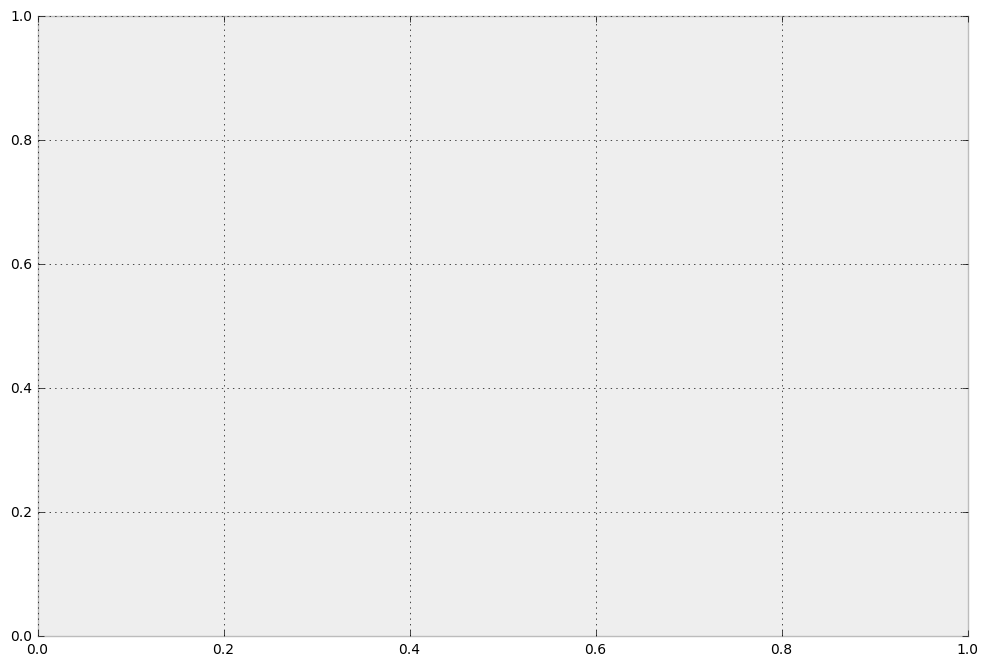

In [101]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df_ppl_sub[df_ppl_sub['Overlapping Indicator'] == 0]['T0-T4'].dropna(),
            color='salmon', alpha=0.7, bins = 100, label = 'Lone Project', normed=True)
ax.hist(df_ppl_sub[df_ppl_sub['Overlapping Indicator'] == 1]['T0-T4'].dropna(),
            color='lightblue', alpha=0.7, bins = 100, label = 'Overlapping Projects', normed=True)
ax.set(title='Histogram of Time for Overlapping Projects',
       ylabel='Count', xlabel = 'Time Duration')
plt.legend()
plt.show()

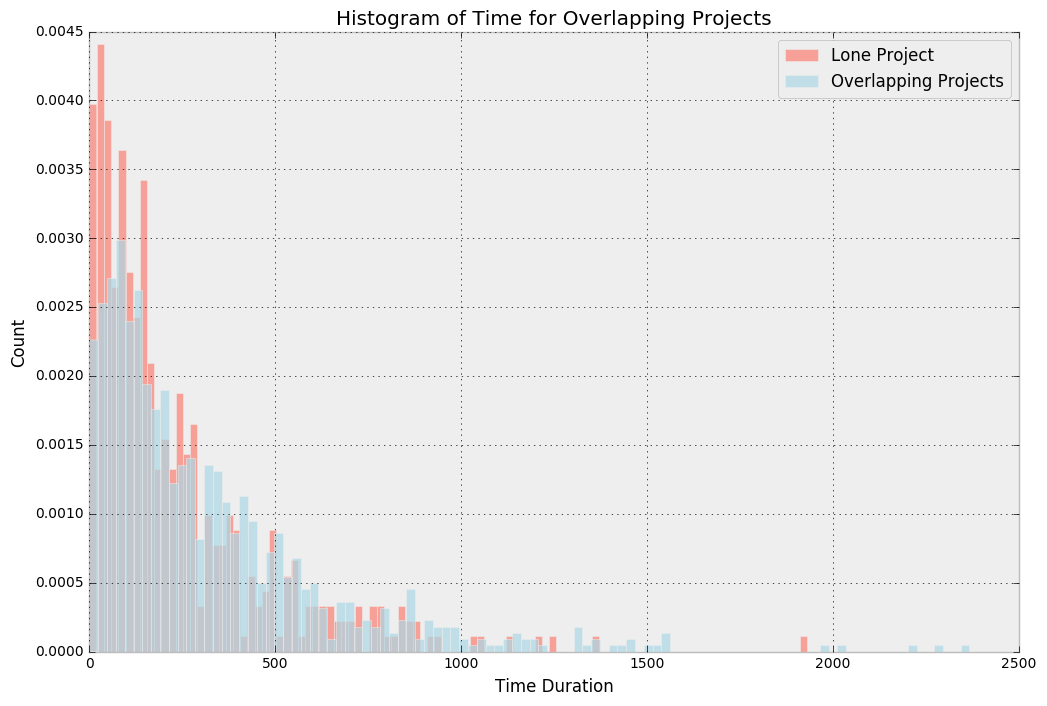

In [83]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df_people[df_people['Overlapping Indicator'] == 0]['TL-T4'].dropna(),
            color='salmon', alpha=0.7, bins = 100, label = 'Lone Project', normed=True)
ax.hist(df_people[df_people['Overlapping Indicator'] == 1]['TL-T4'].dropna(),
            color='lightblue', alpha=0.7, bins = 100, label = 'Overlapping Projects', normed=True)
ax.set(title='Histogram of Time for Overlapping Projects',
       ylabel='Count', xlabel = 'Time Duration')
plt.legend()
plt.show()

In [352]:
clf = linear_model.OLS(df_people['TL-T6'], df_people[['Intercept', 'Overlapping Indicator']], missing = 'drop')
clf = clf.fit()
clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TL-T6   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     40.96
Date:                Wed, 24 Jan 2018   Prob (F-statistic):           2.00e-10
Time:                        15:12:50   Log-Likelihood:                -12277.
No. Observations:                1697   AIC:                         2.456e+04
Df Residuals:                    1695   BIC:                         2.457e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               339.7609     13.729     24.747      0.000     312.833     366.689
Overlapping Indicator   109.1909     17.061      6.400      0.000      75.729     142.653
==============================================================================
Omnibus:                      649.651   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2722.582
Skew:                           1.823   Prob(JB):                         0.00
Kurtosis:                       8.021   Cond. No.                         3.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

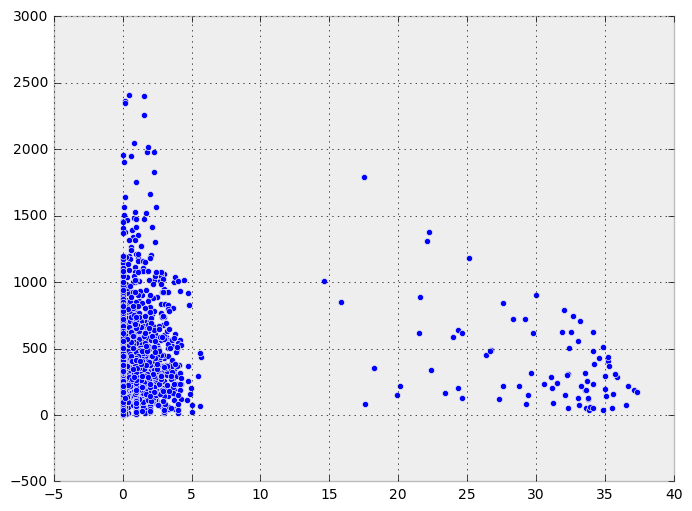

In [336]:
plt.scatter(df_people['Overlapping Percentage'], df_people['TL-T6'])

In [293]:
df_sub_person = df_people[df_people['Project Lead'] == 'Alexander  Frey']
combs = combinations(df_sub_person['PPS Problem #'], 2)
p = list(combs)
pps = p[0]

r1_start = df_sub_person[df_sub_person['PPS Problem #'] == pps[0]]['PTF Launch Date (TL)'].iloc[0].to_pydatetime()
r2_start = df_sub_person[df_sub_person['PPS Problem #'] == pps[1]]['PTF Launch Date (TL)'].iloc[0].to_pydatetime()
r1_end = df_sub_person[df_sub_person['PPS Problem #'] == pps[0]]['Max Step 6 Value'].iloc[0].to_pydatetime()
r2_end = df_sub_person[df_sub_person['PPS Problem #'] == pps[1]]['Max Step 6 Value'].iloc[0].to_pydatetime()

Range = namedtuple('Range', ['start', 'end'])
r1 = Range(start=r1_start, end=r1_end)
r2 = Range(start=r2_start, end=r2_end)
latest_start = max(r1.start, r2.start)
earliest_end = min(r1.end, r2.end)

In [29]:
def getOverlappingDays(r1_start, r1_end, r2_start, r2_end):
    if pd.isnull(r1_start) | pd.isnull(r2_start) | pd.isnull(r1_end) | pd.isnull(r2_end):
        return 0    
    Range = namedtuple('Range', ['start', 'end'])
    r1 = Range(start=r1_start, end=r1_end)
    r2 = Range(start=r2_start, end=r2_end)
    latest_start = max(r1.start, r2.start)
    earliest_end = min(r1.end, r2.end)
    overlap = (earliest_end - latest_start).days + 1    
    if np.isnan(overlap):
        return 0
    if overlap < 0:
        return 0
    else:
        return overlap

In [358]:
df_sub = df_people[['Project Lead', 'Sponsor', 'Service Engineering', 'Engineering', 'Manufacturing', 'Supplier Quality', 'Purchasing', 'Account Management', 'Aftermarket Parts', 'Others']]

In [381]:
df_people['Num_People'] = [len(','.join(df_sub.iloc[x,:].dropna()).split(",")) for x in range(df_sub.shape[0])]

In [391]:
from sklearn.preprocessing import OneHotEncoder

In [394]:
enc = OneHotEncoder()

In [397]:
enc.fit(df_people['Num_People'].values.reshape(-1,1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [405]:
df_cat = pd.DataFrame(enc.transform(df_people['Num_People'].values.reshape(-1,1)).toarray())

In [406]:
df_cat['Intercept'] = 1

In [407]:
clf = linear_model.OLS(df_people['TL-T4'], df_cat, missing = 'drop')
clf = clf.fit()
clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TL-T4   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.499
Date:                Wed, 24 Jan 2018   Prob (F-statistic):           0.000484
Time:                        21:55:16   Log-Likelihood:                -9987.7
No. Observations:                1405   AIC:                         2.001e+04
Df Residuals:                    1386   BIC:                         2.011e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0            -33.3585     36.454     -0.915      0.360    -104.870      38.153
1            146.6067     54.964      2.667      0.008      38.786     254.428
2            -18.3527     44.064     -0.417      0.677    -104.791      68.086
3             32.2677     40.165      0.803      0.422     -46.524     111.059
4             27.4098     36.949      0.742      0.458     -45.072      99.891
5             75.9721     37.926      2.003      0.045       1.574     150.371
6             35.0234     41.028      0.854      0.393     -45.459     115.506
7            124.3543     44.745      2.779      0.006      36.579     212.130
8             76.8892     54.133      1.420      0.156     -29.303     183.082
9            104.3299     71.172      1.466      0.143     -35.287     243.947
10            95.3227     82.318      1.158      0.247     -66.158     256.804
11          -131.0701    105.133     -1.247      0.213    -337.308      75.168
12            -1.4868    119.914     -0.012      0.990    -236.720     233.746
13          -199.9868    166.388     -1.202      0.230    -526.386     126.413
14           -22.3201    202.461     -0.110      0.912    -419.484     374.844
15           104.6799    202.461      0.517      0.605    -292.484     501.844
16            64.6799    284.442      0.227      0.820    -493.304     622.663
17            17.6799    284.442      0.062      0.950    -540.304     575.663
18          -240.3201    284.442     -0.845      0.398    -798.304     317.663
Intercept    258.3201     32.770      7.883      0.000     194.037     322.603
==============================================================================
Omnibus:                      693.371   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4644.886
Skew:                           2.223   Prob(JB):                         0.00
Kurtosis:                      10.719   Cond. No.                     2.24e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.2e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

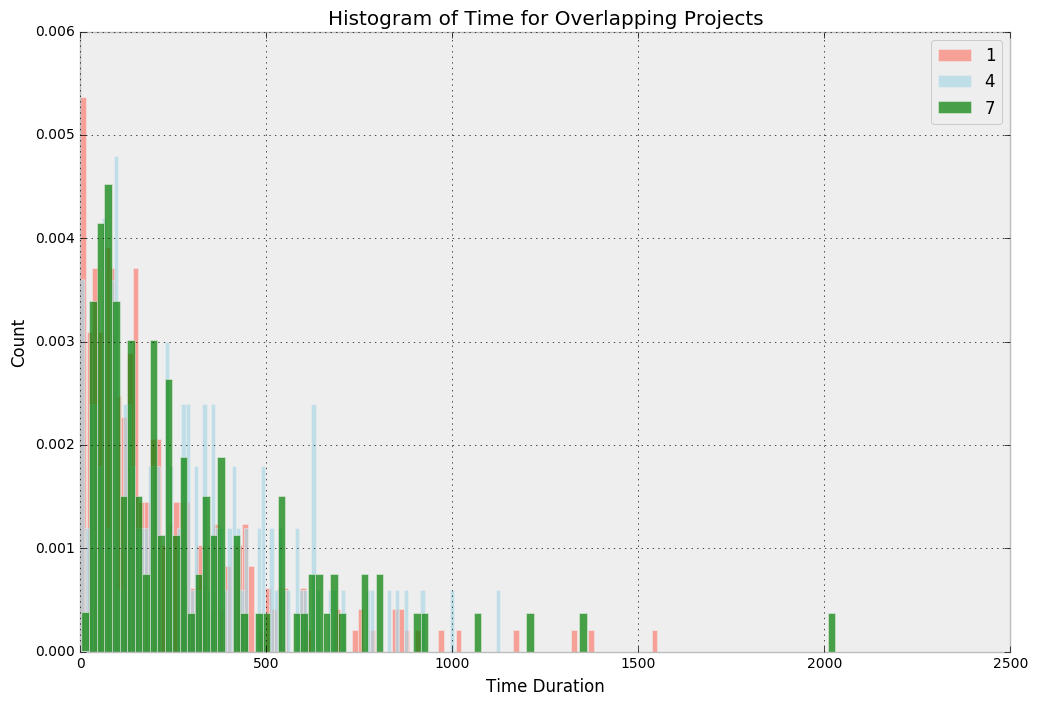

In [385]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df_people[df_people['Num_People'] == 1]['TL-T4'].dropna(),
            color='salmon', alpha=0.7, bins = 100, label = '1', normed=True)
ax.hist(df_people[df_people['Num_People'] == 4]['TL-T4'].dropna(),
            color='lightblue', alpha=0.7, bins = 100, label = '4', normed=True)
ax.hist(df_people[df_people['Num_People'] == 7]['TL-T4'].dropna(),
            color='green', alpha=0.7, bins = 100, label = '7', normed=True)
ax.set(title='Histogram of Time for Overlapping Projects',
       ylabel='Count', xlabel = 'Time Duration')
plt.legend()
plt.show()

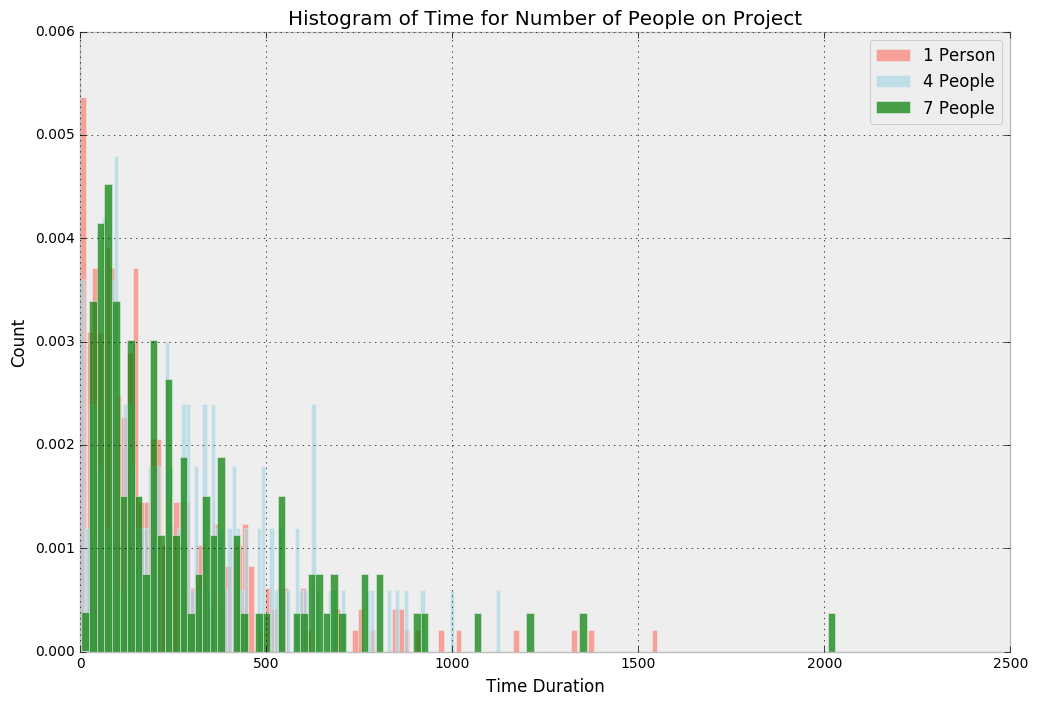

In [388]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df_people[df_people['Num_People'] == 1]['TL-T4'].dropna(),
            color='salmon', alpha=0.7, bins = 100, label = '1 Person', normed=True)
ax.hist(df_people[df_people['Num_People'] == 4]['TL-T4'].dropna(),
            color='lightblue', alpha=0.7, bins = 100, label = '4 People', normed=True)
ax.hist(df_people[df_people['Num_People'] == 7]['TL-T4'].dropna(),
            color='green', alpha=0.7, bins = 100, label = '7 People', normed=True)
ax.set(title='Histogram of Time for Number of People on Project',
       ylabel='Count', xlabel = 'Time Duration')
plt.legend()
plt.show()

In [14]:
df_times

PPS Problem #                                     Entities  \
0      KMFD-8AD4AB                              Engine Business   
1      RGEL-8GJJ9Z                              Engine Business   
2      KMFD-85DKPQ                              Engine Business   
3      MT853-17529  Engine Business,Cummins Emissions Solutions   
4      CFEN-8SKLW4         Engine Business,Cummins Fuel Systems   
5      MC160-18328                                        BFCEC   
6      RSAN-9C3S5U                              Engine Business   
7      FHBY-9GVQU8                              Engine Business   
8      JH229-18238                       Power Systems Business   
9      RMHA-9FUHS9                                        BFCEC   
...            ...                                          ...   
3955   KO340-17228                                          EBU   
3956   KC847-22670                       Power Systems Business   
3957   JSTG-997NXA                                          EBU   
3958   VCHN-9DGCVN                              Engine Business   
3959   JX464-21556                                          EBU   
3960   TARK-8GWT6Q                              Engine Business   
3961   JHUN-99MCSL                              Engine Business   
3962   ME322-24007                                          EBU   
3963   KC427-25928                                          NaN   
3964   KE092-18434                                          EBU   

     Failure Recognition Date First Customer Failure Date (Tc)  \
0                  2010-10-18                              NaT   
1                  2011-05-04                              NaT   
2                  2010-05-12                       2015-08-25   
3                  2014-06-23                       2014-06-23   
4                  2012-03-13                       2015-12-03   
5                  2014-11-17                       2014-10-26   
6                  2013-09-16                       2013-03-01   
7                  2014-03-04                       2012-12-27   
8                  2014-08-12                       2014-01-24   
9                  2014-01-05                       2013-11-24   
...                       ...                              ...   
3955               2014-03-04                       2012-12-27   
3956               2016-01-20                       2015-11-20   
3957               2013-04-11                       2013-03-20   
3958               2013-10-07                       2013-06-04   
3959               2014-06-20                       2014-04-30   
3960               2011-03-09                              NaT   
3961               2012-06-29                              NaT   
3962               2016-03-11                       2016-03-10   
3963               2016-07-05                       2016-05-02   
3964               2014-06-11                       2013-12-19   

     PDF Approval Date (T1) PTF Launch Date (TL) Preliminary Step 2  \
0                2010-10-22           2010-11-16                NaT   
1                2011-05-04           2011-07-12         2011-09-10   
2                2010-05-13           2010-06-02         2012-01-13   
3                2015-06-18           2015-07-16         2015-07-17   
4                2012-03-29           2012-10-16         2012-11-01   
5                2014-11-20           2015-01-12         2015-02-15   
6                2013-12-18           2014-07-09         2014-08-11   
7                2014-03-05           2015-02-19         2015-03-25   
8                2014-11-12           2016-10-20         2016-10-20   
9                2014-06-02           2014-06-03         2015-01-23   
...                     ...                  ...                ...   
3955                    NaT                  NaT                NaT   
3956             2016-02-03                  NaT                NaT   
3957                    NaT                  NaT                NaT   
3958        

In [13]:
df[['Project Lead']]

Project Lead
0        John G Foscolos
1          Rodrigo  Hono
2        John G Foscolos
3               Xuan  Wu
4      Jitendra  Agrawal
5            Huaiwu  Liu
6          Cass  Custard
7         Abhijit  Patil
8     Shriram  Parandkar
9           Ian  Peacock
...                  ...
5261                 NaN
5262                 NaN
5266                 NaN
5377                 NaN
5452                 NaN
5523                 NaN
5579                 NaN
5751                 NaN
5772                 NaN
5784                 NaN

[3965 rows x 1 columns]